In [19]:
import numpy as np
import pandas as pd
import pyswarms as ps
from collections import defaultdict
import random
import matplotlib.pyplot as plt
import yfinance as yf
import pandas as pd


# Q-learning agent con decaimiento
class QLearningAgent:
    def __init__(self, actions, initial_learning_rate=0.01, initial_discount_factor=0.95, initial_exploration_rate=0.3):
        self.q_table = defaultdict(lambda: np.zeros(len(actions)))
        self.actions = actions
        self.initial_learning_rate = initial_learning_rate
        self.learning_rate = initial_learning_rate
        self.initial_discount_factor = initial_discount_factor
        self.discount_factor = initial_discount_factor
        self.initial_exploration_rate = initial_exploration_rate
        self.exploration_rate = initial_exploration_rate
        self.episode = 0

    def choose_action(self, state):
        if np.random.rand() < self.exploration_rate:
            return np.random.randint(len(self.actions))  # Asegurarse de devolver un índice entero
        else:
            return np.argmax(self.q_table[state])

    def learn(self, state, action, reward, next_state):
        best_next_action = np.argmax(self.q_table[next_state])
        td_target = reward + self.discount_factor * self.q_table[next_state][best_next_action]
        td_error = td_target - self.q_table[state][action]
        self.q_table[state][action] += self.learning_rate * td_error

    def decay_parameters(self, decay_rate=0.99):
        self.learning_rate = self.initial_learning_rate * (decay_rate ** self.episode)
        self.discount_factor = self.initial_discount_factor * (decay_rate ** self.episode)
        self.exploration_rate = self.initial_exploration_rate * (decay_rate ** self.episode)
        self.episode += 1

In [20]:
# PSO parameters
c1_actions = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
c2_actions = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
w_actions = [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5]

# Initialize Q-learning agents for c1, c2, and w
c1_agent = QLearningAgent(actions=c1_actions, initial_learning_rate=0.01, initial_discount_factor=0.95, initial_exploration_rate=0.3)
c2_agent = QLearningAgent(actions=c2_actions, initial_learning_rate=0.01, initial_discount_factor=0.95, initial_exploration_rate=0.3)
w_agent = QLearningAgent(actions=w_actions, initial_learning_rate=0.01, initial_discount_factor=0.95, initial_exploration_rate=0.3)


In [21]:
# Definimos los tickers de los activos financieros
tickers = ['HLVX', 'CLEU', 'SHPW', 'VRPX', 'ZAPP', 'SVMH', 'CERO']
data = yf.download(tickers, start='2017-01-01', end='2024-07-08')['Adj Close']
#print(data.head())

data.to_csv('financial_data.csv')

[*********************100%%**********************]  7 of 7 completed


In [22]:
# Leemos los datos financieros descargados
data = pd.read_csv('financial_data.csv', index_col=0)

# Calculamos los rendimientos diarios
returns = data.pct_change().dropna()

# Número de activos
num_assets = len(tickers)

# Función de recompensa (Sharpe Ratio) con tasa libre de riesgo de 2%
def sharpe_ratio(weights):
    portfolio_return = np.sum(returns.mean().values * weights, axis=1) * 252
    portfolio_std = np.sqrt(np.einsum('ij,ji->i', np.dot(weights, returns.cov().values * 252), weights.T))
    return portfolio_return / portfolio_std

# Función objetivo para la optimización (maximizar Sharpe Ratio)
def objective_function(weights):
    # Normalizamos las ponderaciones para que sumen 1
    normalized_weights = weights / np.sum(weights, axis=1)[:, None]
    return -sharpe_ratio(normalized_weights)

# Definimos los límites para las posiciones de las partículas
bounds = (np.zeros(num_assets), np.ones(num_assets))


C:\Users\titox\AppData\Local\Temp\ipykernel_17944\615260507.py:5: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = data.pct_change().dropna()


In [23]:
# Parámetros iniciales
c1, c2, w = 0.5, 0.5, 0.9
state = (c1, c2, w)

# Almacenamiento de resultados
episodes = []
sharpe_ratios = []
portfolio_weights = []
c1_values = []
c2_values = []
w_values = []

# Variables para almacenar la mejor configuración
best_sharpe_ratio = -np.inf
best_portfolio_weights = None
best_pso_params = None

# Entrenamos el agente con múltiples episodios
num_episodes = 200
num_iterations = 100

for episode in range(num_episodes):
    # Decaimiento de los parámetros
    c1_agent.decay_parameters()
    c2_agent.decay_parameters()
    w_agent.decay_parameters()

    # Elegir parámetros usando Q-learning
    c1_index = int(c1_agent.choose_action(state))  # Convertir a entero
    c2_index = int(c2_agent.choose_action(state))  # Convertir a entero
    w_index = int(w_agent.choose_action(state))  # Convertir a entero

    c1 = c1_actions[c1_index]
    c2 = c2_actions[c2_index]
    w = w_actions[w_index]
    options = {'c1': c1, 'c2': c2, 'w': w}

    # Inicializamos el optimizador
    optimizer = ps.single.GlobalBestPSO(n_particles=100, dimensions=num_assets, options=options, bounds=bounds)

    # Ejecutamos la optimización
    best_cost, best_pos = optimizer.optimize(objective_function, iters=num_iterations)

    # Calcular recompensa (negativo del mejor costo, ya que estamos maximizando)
    reward = -best_cost

    # Aprender de la recompensa
    next_state = (c1, c2, w)
    c1_agent.learn(state, c1_index, reward, next_state)
    c2_agent.learn(state, c2_index, reward, next_state)
    w_agent.learn(state, w_index, reward, next_state)
    state = next_state

    # Normalizamos las mejores ponderaciones
    best_pos = best_pos / np.sum(best_pos)

    # Almacenar la mejor configuración
    if -best_cost > best_sharpe_ratio:
        best_sharpe_ratio = -best_cost
        best_portfolio_weights = best_pos
        best_pso_params = options

    # Almacenar resultados del episodio
    episodes.append(episode + 1)
    sharpe_ratios.append(-best_cost)
    portfolio_weights.append(best_pos)
    c1_values.append(c1)
    c2_values.append(c2)
    w_values.append(w)

    # Mostramos los resultados
    print(f"Episode {episode + 1}:")
    print("Best Portfolio Weights:", best_pos)
    print("Best Sharpe Ratio:", -best_cost)
    print("Parameters - c1:", c1, "c2:", c2, "w:", w)

# Convertir los resultados de ponderaciones a un array para facilitar la graficación
portfolio_weights = np.array(portfolio_weights)


2024-07-09 01:22:34,944 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.5, 'c2': 0.6, 'w': 0.7}
pyswarms.single.global_best: 100%|██████████|100/100, best_cost=0.0574
2024-07-09 01:22:35,077 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.05744098656532409, best pos: [0.04512072 0.92729624 0.24247272 0.03252078 0.05287228 0.00215113
 0.10716936]
2024-07-09 01:22:35,082 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.1, 'c2': 0.1, 'w': 0.4}


Episode 1:
Best Portfolio Weights: [0.03200952 0.65784202 0.17201487 0.02307088 0.03750863 0.00152605
 0.07602803]
Best Sharpe Ratio: -0.05744098656532409
Parameters - c1: 0.5 c2: 0.6 w: 0.7


pyswarms.single.global_best: 100%|██████████|100/100, best_cost=0.516
2024-07-09 01:22:35,212 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.5161454119879532, best pos: [0.10684338 0.9939699  0.62883594 0.32459873 0.55823549 0.00294709
 0.26446168]
2024-07-09 01:22:35,217 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.1, 'c2': 0.1, 'w': 0.4}


Episode 2:
Best Portfolio Weights: [0.03709978 0.34514135 0.21835398 0.11271211 0.19383902 0.00102333
 0.09183041]
Best Sharpe Ratio: -0.5161454119879532
Parameters - c1: 0.1 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|100/100, best_cost=0.335
2024-07-09 01:22:35,349 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.33506313818402933, best pos: [0.0618743  0.97203763 0.85060141 0.16557659 0.02682952 0.14559527
 0.78222744]
2024-07-09 01:22:35,354 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.9, 'c2': 0.6, 'w': 0.5}


Episode 3:
Best Portfolio Weights: [0.02059222 0.32350118 0.28308632 0.05510509 0.00892906 0.04845516
 0.26033097]
Best Sharpe Ratio: -0.33506313818402933
Parameters - c1: 0.1 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|100/100, best_cost=0.212
2024-07-09 01:22:35,489 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.2120043670172331, best pos: [0.00539134 0.97612607 0.47872245 0.01470855 0.20195847 0.0342316
 0.57217421]
2024-07-09 01:22:35,494 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.1, 'c2': 0.2, 'w': 0.7}


Episode 4:
Best Portfolio Weights: [0.00236119 0.42750433 0.20966136 0.00644176 0.08844976 0.01499208
 0.25058951]
Best Sharpe Ratio: -0.2120043670172331
Parameters - c1: 0.9 c2: 0.6 w: 0.5


pyswarms.single.global_best: 100%|██████████|100/100, best_cost=0.0349
2024-07-09 01:22:35,624 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.034922614502436555, best pos: [4.48885231e-04 9.99540428e-01 8.58801541e-01 1.26609251e-02
 4.92510222e-02 4.40432645e-02 2.11813771e-01]
2024-07-09 01:22:35,628 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.1, 'c2': 0.1, 'w': 0.4}


Episode 5:
Best Portfolio Weights: [2.06236109e-04 4.59229473e-01 3.94568312e-01 5.81694328e-03
 2.26279201e-02 2.02352647e-02 9.73158503e-02]
Best Sharpe Ratio: -0.034922614502436555
Parameters - c1: 0.1 c2: 0.2 w: 0.7


pyswarms.single.global_best: 100%|██████████|100/100, best_cost=0.481
2024-07-09 01:22:35,763 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.4810856599493617, best pos: [0.32983821 0.93248003 0.52730644 0.03065594 0.19040651 0.08189707
 0.98736808]
2024-07-09 01:22:35,767 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.2, 'c2': 0.2, 'w': 1.3}


Episode 6:
Best Portfolio Weights: [0.10709199 0.30275795 0.17120604 0.00995338 0.06182125 0.02659037
 0.32057902]
Best Sharpe Ratio: -0.4810856599493617
Parameters - c1: 0.1 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|100/100, best_cost=0.166
2024-07-09 01:22:35,952 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.16587195814623162, best pos: [0.00570723 0.82162291 0.95069885 0.16154583 0.12976387 0.00775245
 0.14540356]
2024-07-09 01:22:35,959 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.1, 'c2': 0.1, 'w': 0.4}


Episode 7:
Best Portfolio Weights: [0.00256794 0.36968498 0.42776203 0.07268671 0.05838658 0.00348818
 0.06542358]
Best Sharpe Ratio: -0.16587195814623162
Parameters - c1: 0.2 c2: 0.2 w: 1.3


pyswarms.single.global_best: 100%|██████████|100/100, best_cost=0.455
2024-07-09 01:22:36,089 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.4548744877203708, best pos: [0.14892673 0.88355867 0.24102788 0.02682602 0.08199449 0.34033101
 0.23621126]
2024-07-09 01:22:36,096 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.3, 'c2': 0.3, 'w': 0.6}


Episode 8:
Best Portfolio Weights: [0.07602662 0.45105389 0.12304397 0.0136946  0.04185793 0.1737379
 0.1205851 ]
Best Sharpe Ratio: -0.4548744877203708
Parameters - c1: 0.1 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|100/100, best_cost=-0.0517
2024-07-09 01:22:36,245 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -0.05168224915254873, best pos: [6.65328994e-04 8.40577352e-01 9.05234493e-01 7.60749766e-03
 3.87304422e-02 9.15852912e-04 6.33575433e-02]
2024-07-09 01:22:36,252 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.4, 'c2': 0.1, 'w': 0.4}


Episode 9:
Best Portfolio Weights: [3.58264558e-04 4.52631820e-01 4.87448222e-01 4.09646477e-03
 2.08554638e-02 4.93166000e-04 3.41165986e-02]
Best Sharpe Ratio: 0.05168224915254873
Parameters - c1: 0.3 c2: 0.3 w: 0.6


pyswarms.single.global_best: 100%|██████████|100/100, best_cost=0.444
2024-07-09 01:22:36,363 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.44386470358817015, best pos: [0.17978635 0.80774234 0.51511888 0.02057504 0.52564279 0.10786768
 0.00810536]
2024-07-09 01:22:36,367 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.1, 'c2': 0.1, 'w': 1.3}


Episode 10:
Best Portfolio Weights: [0.08304839 0.37311899 0.23794796 0.00950419 0.24280925 0.04982712
 0.0037441 ]
Best Sharpe Ratio: -0.44386470358817015
Parameters - c1: 0.4 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|100/100, best_cost=0.199
2024-07-09 01:22:36,481 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.19864165079227153, best pos: [0.09469283 0.92570029 0.46241616 0.03031088 0.00969908 0.07710405
 0.29105674]
2024-07-09 01:22:36,486 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.1, 'c2': 0.1, 'w': 0.4}


Episode 11:
Best Portfolio Weights: [0.05007606 0.48953467 0.24453783 0.01602919 0.00512913 0.04077465
 0.15391847]
Best Sharpe Ratio: -0.19864165079227153
Parameters - c1: 0.1 c2: 0.1 w: 1.3


pyswarms.single.global_best: 100%|██████████|100/100, best_cost=0.417
2024-07-09 01:22:36,627 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.4165811051582591, best pos: [0.07706533 0.46488777 0.7260146  0.17368718 0.03715833 0.05256848
 0.12691627]
2024-07-09 01:22:36,633 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.3, 'c2': 0.3, 'w': 1.5}


Episode 12:
Best Portfolio Weights: [0.04647255 0.28034032 0.43780709 0.10473822 0.02240751 0.03170026
 0.07653405]
Best Sharpe Ratio: -0.4165811051582591
Parameters - c1: 0.1 c2: 0.1 w: 0.4


pyswarms.single.global_best:  60%|██████    |60/100, best_cost=0.106C:\Users\titox\AppData\Local\Temp\ipykernel_17944\615260507.py:19: RuntimeWarning: invalid value encountered in divide
  normalized_weights = weights / np.sum(weights, axis=1)[:, None]
pyswarms.single.global_best: 100%|██████████|100/100, best_cost=-0.109
2024-07-09 01:22:36,817 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -0.10864901529019702, best pos: [0.  0.5 0.5 0.  0.  0.  0. ]
2024-07-09 01:22:36,823 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.1, 'c2': 0.1, 'w': 0.4}


Episode 13:
Best Portfolio Weights: [0.  0.5 0.5 0.  0.  0.  0. ]
Best Sharpe Ratio: 0.10864901529019702
Parameters - c1: 0.3 c2: 0.3 w: 1.5


pyswarms.single.global_best: 100%|██████████|100/100, best_cost=0.396
2024-07-09 01:22:36,952 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.39579295310956214, best pos: [0.10189551 0.91635926 0.54891902 0.14152338 0.26088526 0.03808552
 0.52719878]
2024-07-09 01:22:36,956 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.2, 'c2': 0.3, 'w': 1.5}


Episode 14:
Best Portfolio Weights: [0.04019758 0.36150195 0.21654749 0.0558307  0.10291873 0.01502466
 0.20797889]
Best Sharpe Ratio: -0.39579295310956214
Parameters - c1: 0.1 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|100/100, best_cost=-0.109
2024-07-09 01:22:37,084 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -0.10916599916827534, best pos: [0.    0.75  0.875 0.    0.    0.    0.   ]
2024-07-09 01:22:37,089 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.1, 'c2': 0.1, 'w': 0.4}


Episode 15:
Best Portfolio Weights: [0.         0.46153846 0.53846154 0.         0.         0.
 0.        ]
Best Sharpe Ratio: 0.10916599916827534
Parameters - c1: 0.2 c2: 0.3 w: 1.5


pyswarms.single.global_best: 100%|██████████|100/100, best_cost=0.522
2024-07-09 01:22:37,214 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.5220341020854914, best pos: [0.04367812 0.53846992 0.42759001 0.17047138 0.40826937 0.06743674
 0.72589332]
2024-07-09 01:22:37,219 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.3, 'c2': 0.3, 'w': 1.5}


Episode 16:
Best Portfolio Weights: [0.01833822 0.22607604 0.17952323 0.07157223 0.17141147 0.02831325
 0.30476556]
Best Sharpe Ratio: -0.5220341020854914
Parameters - c1: 0.1 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|100/100, best_cost=-0.104
2024-07-09 01:22:37,362 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -0.10428813865323693, best pos: [0.   0.5  0.25 0.   0.   0.   0.  ]
2024-07-09 01:22:37,367 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.2, 'c2': 0.2, 'w': 0.5}


Episode 17:
Best Portfolio Weights: [0.         0.66666667 0.33333333 0.         0.         0.
 0.        ]
Best Sharpe Ratio: 0.10428813865323693
Parameters - c1: 0.3 c2: 0.3 w: 1.5


pyswarms.single.global_best: 100%|██████████|100/100, best_cost=0.413
2024-07-09 01:22:37,586 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.41341952413609323, best pos: [0.0028279  0.65812495 0.69551074 0.00723817 0.31773147 0.27646202
 0.79601705]
2024-07-09 01:22:37,591 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.1, 'c2': 0.1, 'w': 1.5}


Episode 18:
Best Portfolio Weights: [0.00102687 0.23897818 0.2525537  0.00262832 0.11537458 0.10038883
 0.28904953]
Best Sharpe Ratio: -0.41341952413609323
Parameters - c1: 0.2 c2: 0.2 w: 0.5


pyswarms.single.global_best: 100%|██████████|100/100, best_cost=-0.109
2024-07-09 01:22:37,838 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -0.10932501180535109, best pos: [0.    0.375 0.5   0.    0.    0.    0.   ]
2024-07-09 01:22:37,843 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.1, 'c2': 0.1, 'w': 0.4}


Episode 19:
Best Portfolio Weights: [0.         0.42857143 0.57142857 0.         0.         0.
 0.        ]
Best Sharpe Ratio: 0.10932501180535109
Parameters - c1: 0.1 c2: 0.1 w: 1.5


pyswarms.single.global_best: 100%|██████████|100/100, best_cost=0.463
2024-07-09 01:22:38,028 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.46274492850801763, best pos: [0.07903634 0.63088962 0.86533869 0.17996182 0.27680194 0.1018173
 0.91286606]
2024-07-09 01:22:38,033 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.3, 'c2': 0.3, 'w': 1.5}


Episode 20:
Best Portfolio Weights: [0.02594152 0.2070723  0.28402381 0.05906756 0.09085268 0.03341875
 0.29962337]
Best Sharpe Ratio: -0.46274492850801763
Parameters - c1: 0.1 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|100/100, best_cost=-0.0947
2024-07-09 01:22:38,188 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -0.094692698191791, best pos: [0.  0.5 0.  0.  0.  0.  0. ]
2024-07-09 01:22:38,193 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.3, 'c2': 0.3, 'w': 0.6}


Episode 21:
Best Portfolio Weights: [0. 1. 0. 0. 0. 0. 0.]
Best Sharpe Ratio: 0.094692698191791
Parameters - c1: 0.3 c2: 0.3 w: 1.5


pyswarms.single.global_best: 100%|██████████|100/100, best_cost=-0.0473
2024-07-09 01:22:38,357 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -0.0473029581231499, best pos: [0.00394048 0.97767457 0.34636944 0.03771218 0.00441906 0.01220202
 0.02067584]
2024-07-09 01:22:38,364 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.1, 'c2': 0.2, 'w': 0.5}


Episode 22:
Best Portfolio Weights: [0.00280862 0.69684892 0.24687885 0.02687979 0.00314974 0.00869713
 0.01473694]
Best Sharpe Ratio: 0.0473029581231499
Parameters - c1: 0.3 c2: 0.3 w: 0.6


pyswarms.single.global_best: 100%|██████████|100/100, best_cost=0.274
2024-07-09 01:22:38,493 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.27428908816485353, best pos: [3.06264726e-04 6.33737463e-01 7.37697500e-01 3.42292075e-02
 2.20765726e-01 6.43849662e-02 3.87797873e-01]
2024-07-09 01:22:38,496 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.4, 'c2': 0.1, 'w': 1.3}


Episode 23:
Best Portfolio Weights: [1.47319220e-04 3.04839901e-01 3.54846678e-01 1.64649068e-02
 1.06192558e-01 3.09704063e-02 1.86538231e-01]
Best Sharpe Ratio: -0.27428908816485353
Parameters - c1: 0.1 c2: 0.2 w: 0.5


pyswarms.single.global_best: 100%|██████████|100/100, best_cost=0.295
2024-07-09 01:22:38,628 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.29453379236590815, best pos: [0.21689364 0.8942015  0.1803897  0.04161245 0.11128845 0.04263739
 0.03682634]
2024-07-09 01:22:38,634 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.1, 'c2': 0.1, 'w': 0.4}


Episode 24:
Best Portfolio Weights: [0.14233272 0.58680435 0.11837764 0.02730746 0.07303113 0.02798005
 0.02416665]
Best Sharpe Ratio: -0.29453379236590815
Parameters - c1: 0.4 c2: 0.1 w: 1.3


pyswarms.single.global_best: 100%|██████████|100/100, best_cost=0.605
2024-07-09 01:22:38,784 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.6046463086505296, best pos: [0.12572062 0.94453606 0.28811054 0.17190303 0.9400321  0.07043047
 0.41962273]
2024-07-09 01:22:38,789 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.3, 'c2': 0.3, 'w': 1.5}


Episode 25:
Best Portfolio Weights: [0.04246808 0.3190617  0.09732295 0.05806837 0.31754027 0.02379122
 0.14174741]
Best Sharpe Ratio: -0.6046463086505296
Parameters - c1: 0.1 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|100/100, best_cost=-0.109
2024-07-09 01:22:38,918 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -0.10864901529019702, best pos: [0.  0.5 0.5 0.  0.  0.  0. ]
2024-07-09 01:22:38,922 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.3, 'c2': 0.3, 'w': 0.6}


Episode 26:
Best Portfolio Weights: [0.  0.5 0.5 0.  0.  0.  0. ]
Best Sharpe Ratio: 0.10864901529019702
Parameters - c1: 0.3 c2: 0.3 w: 1.5


pyswarms.single.global_best: 100%|██████████|100/100, best_cost=0.0904
2024-07-09 01:22:39,049 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.09035299691316795, best pos: [0.00216028 0.9981565  0.8230454  0.00196433 0.263916   0.00765969
 0.1984703 ]
2024-07-09 01:22:39,052 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.2, 'c2': 0.3, 'w': 0.6}


Episode 27:
Best Portfolio Weights: [0.00094115 0.434856   0.35856724 0.00085578 0.11497742 0.00333702
 0.0864654 ]
Best Sharpe Ratio: -0.09035299691316795
Parameters - c1: 0.3 c2: 0.3 w: 0.6


pyswarms.single.global_best: 100%|██████████|100/100, best_cost=0.14
2024-07-09 01:22:39,177 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.14000896968105073, best pos: [0.00876465 0.99505926 0.22926971 0.0043437  0.10333858 0.07166562
 0.33545955]
2024-07-09 01:22:39,181 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.1, 'c2': 0.1, 'w': 0.4}


Episode 28:
Best Portfolio Weights: [0.00501438 0.56928809 0.13116859 0.0024851  0.05912153 0.04100096
 0.19192136]
Best Sharpe Ratio: -0.14000896968105073
Parameters - c1: 0.2 c2: 0.3 w: 0.6


pyswarms.single.global_best: 100%|██████████|100/100, best_cost=0.41
2024-07-09 01:22:39,295 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.4101274424248051, best pos: [0.05574681 0.81472849 0.93817567 0.0322125  0.95563454 0.01506954
 0.22247865]
2024-07-09 01:22:39,301 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.3, 'c2': 0.8, 'w': 1.5}


Episode 29:
Best Portfolio Weights: [0.01837375 0.2685287  0.30921601 0.01061701 0.31497033 0.00496681
 0.07332738]
Best Sharpe Ratio: -0.4101274424248051
Parameters - c1: 0.1 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|100/100, best_cost=-0.0947
2024-07-09 01:22:39,423 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -0.094692698191791, best pos: [0.     0.6875 0.     0.     0.     0.     0.    ]
2024-07-09 01:22:39,427 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.1, 'c2': 0.1, 'w': 0.4}


Episode 30:
Best Portfolio Weights: [0. 1. 0. 0. 0. 0. 0.]
Best Sharpe Ratio: 0.094692698191791
Parameters - c1: 0.3 c2: 0.8 w: 1.5


pyswarms.single.global_best: 100%|██████████|100/100, best_cost=0.558
2024-07-09 01:22:39,544 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.5575938630906411, best pos: [0.18166999 0.81859119 0.91573656 0.26266634 0.25880165 0.14262388
 0.79574689]
2024-07-09 01:22:39,553 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.3, 'c2': 0.3, 'w': 1.5}


Episode 31:
Best Portfolio Weights: [0.05381481 0.24248544 0.27126212 0.07780778 0.07666297 0.04224846
 0.23571843]
Best Sharpe Ratio: -0.5575938630906411
Parameters - c1: 0.1 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|100/100, best_cost=-0.109
2024-07-09 01:22:39,702 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -0.10919034823683939, best pos: [0.   0.5  0.75 0.   0.   0.   0.  ]
2024-07-09 01:22:39,707 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.4, 'c2': 0.4, 'w': 0.7}


Episode 32:
Best Portfolio Weights: [0.  0.4 0.6 0.  0.  0.  0. ]
Best Sharpe Ratio: 0.10919034823683939
Parameters - c1: 0.3 c2: 0.3 w: 1.5


pyswarms.single.global_best: 100%|██████████|100/100, best_cost=0.196
2024-07-09 01:22:39,825 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.19612080915856453, best pos: [0.01167053 0.89947711 0.62936517 0.00570579 0.1656782  0.00281564
 0.59393715]
2024-07-09 01:22:39,829 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.9, 'c2': 0.1, 'w': 0.4}


Episode 33:
Best Portfolio Weights: [0.00505513 0.38961179 0.27261182 0.00247148 0.07176412 0.00121961
 0.25726604]
Best Sharpe Ratio: -0.19612080915856453
Parameters - c1: 0.4 c2: 0.4 w: 0.7


pyswarms.single.global_best: 100%|██████████|100/100, best_cost=0.351
2024-07-09 01:22:39,948 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.3505518275629611, best pos: [0.0580408  0.9987984  0.91843941 0.13994397 0.25937414 0.18208558
 0.31307946]
2024-07-09 01:22:39,953 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.9, 'c2': 0.5, 'w': 0.4}


Episode 34:
Best Portfolio Weights: [0.02022495 0.34804227 0.3200403  0.04876501 0.09038177 0.06344972
 0.10909597]
Best Sharpe Ratio: -0.3505518275629611
Parameters - c1: 0.9 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|100/100, best_cost=0.208
2024-07-09 01:22:40,074 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.20809217297969493, best pos: [0.00183811 0.45591584 0.42275978 0.00229814 0.36453333 0.00747523
 0.0049152 ]
2024-07-09 01:22:40,080 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.8, 'c2': 0.1, 'w': 0.4}


Episode 35:
Best Portfolio Weights: [0.00145912 0.36191391 0.33559405 0.0018243  0.28937288 0.00593397
 0.00390177]
Best Sharpe Ratio: -0.20809217297969493
Parameters - c1: 0.9 c2: 0.5 w: 0.4


pyswarms.single.global_best: 100%|██████████|100/100, best_cost=0.261
2024-07-09 01:22:40,204 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.2610267373495599, best pos: [0.0354555  0.8374256  0.64812232 0.02987681 0.12638216 0.07293275
 0.58856143]
2024-07-09 01:22:40,209 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.1, 'c2': 0.1, 'w': 0.4}


Episode 36:
Best Portfolio Weights: [0.01515998 0.35806445 0.27712261 0.01277466 0.05403818 0.03118441
 0.2516557 ]
Best Sharpe Ratio: -0.2610267373495599
Parameters - c1: 0.8 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|100/100, best_cost=0.546
2024-07-09 01:22:40,333 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.546150849137875, best pos: [0.2689587  0.97451442 0.07637562 0.32070659 0.05796981 0.04827298
 0.90566637]
2024-07-09 01:22:40,338 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.3, 'c2': 0.3, 'w': 1.5}


Episode 37:
Best Portfolio Weights: [0.10139955 0.36739961 0.02879421 0.12090891 0.02185508 0.01819929
 0.34144335]
Best Sharpe Ratio: -0.546150849137875
Parameters - c1: 0.1 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|100/100, best_cost=-0.0947
2024-07-09 01:22:40,508 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -0.094692698191791, best pos: [0.  0.5 0.  0.  0.  0.  0. ]


Episode 38:
Best Portfolio Weights: [0. 1. 0. 0. 0. 0. 0.]
Best Sharpe Ratio: 0.094692698191791
Parameters - c1: 0.3 c2: 0.3 w: 1.5


2024-07-09 01:22:40,518 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.5, 'c2': 0.2, 'w': 0.8}
pyswarms.single.global_best: 100%|██████████|100/100, best_cost=0.0853
2024-07-09 01:22:40,645 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.08530327126718072, best pos: [0.02310694 0.94668283 0.39749516 0.07137166 0.10005632 0.03873789
 0.06643313]
2024-07-09 01:22:40,650 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.6, 'c2': 0.1, 'w': 0.4}


Episode 39:
Best Portfolio Weights: [0.01405631 0.5758818  0.24180245 0.04341648 0.06086581 0.02356486
 0.0404123 ]
Best Sharpe Ratio: -0.08530327126718072
Parameters - c1: 0.5 c2: 0.2 w: 0.8


pyswarms.single.global_best: 100%|██████████|100/100, best_cost=0.572
2024-07-09 01:22:40,766 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.5715988267577581, best pos: [0.0502104  0.69247918 0.29953894 0.0551949  0.5292588  0.25725625
 0.56334186]
2024-07-09 01:22:40,771 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.1, 'c2': 0.1, 'w': 0.7}


Episode 40:
Best Portfolio Weights: [0.02051682 0.28295867 0.12239666 0.02255357 0.21626407 0.10511924
 0.23019098]
Best Sharpe Ratio: -0.5715988267577581
Parameters - c1: 0.6 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|100/100, best_cost=0.106
2024-07-09 01:22:40,911 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.10591212515057187, best pos: [2.61723268e-03 8.46932859e-01 6.78262737e-01 5.36541667e-03
 1.02439389e-03 6.13953982e-04 4.75299329e-01]
2024-07-09 01:22:40,915 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.1, 'c2': 0.1, 'w': 0.4}


Episode 41:
Best Portfolio Weights: [1.30203072e-03 4.21335332e-01 3.37424688e-01 2.66920758e-03
 5.09619312e-04 3.05432127e-04 2.36453691e-01]
Best Sharpe Ratio: -0.10591212515057187
Parameters - c1: 0.1 c2: 0.1 w: 0.7


pyswarms.single.global_best: 100%|██████████|100/100, best_cost=0.478
2024-07-09 01:22:41,038 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.47800693729245425, best pos: [0.02563507 0.99332167 0.61873678 0.34390381 0.21750129 0.23763728
 0.24789993]
2024-07-09 01:22:41,043 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.7, 'c2': 0.3, 'w': 1.5}


Episode 42:
Best Portfolio Weights: [0.00954881 0.37000239 0.23047326 0.12810073 0.08101706 0.08851751
 0.09234025]
Best Sharpe Ratio: -0.47800693729245425
Parameters - c1: 0.1 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|100/100, best_cost=-0.0947
2024-07-09 01:22:41,174 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -0.094692698191791, best pos: [0.  0.5 0.  0.  0.  0.  0. ]
2024-07-09 01:22:41,178 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.1, 'c2': 0.1, 'w': 0.4}


Episode 43:
Best Portfolio Weights: [0. 1. 0. 0. 0. 0. 0.]
Best Sharpe Ratio: 0.094692698191791
Parameters - c1: 0.7 c2: 0.3 w: 1.5


pyswarms.single.global_best: 100%|██████████|100/100, best_cost=0.475
2024-07-09 01:22:41,333 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.47503664538701995, best pos: [0.03732663 0.52806034 0.49170375 0.35175875 0.01846698 0.05823717
 0.84002976]
2024-07-09 01:22:41,338 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.3, 'c2': 0.3, 'w': 1.5}


Episode 44:
Best Portfolio Weights: [0.01605044 0.22706575 0.21143243 0.15125614 0.0079408  0.02504196
 0.36121249]
Best Sharpe Ratio: -0.47503664538701995
Parameters - c1: 0.1 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|100/100, best_cost=-0.0947
2024-07-09 01:22:41,477 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -0.094692698191791, best pos: [0.  0.5 0.  0.  0.  0.  0. ]
2024-07-09 01:22:41,483 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.6, 'c2': 0.5, 'w': 1.2}


Episode 45:
Best Portfolio Weights: [0. 1. 0. 0. 0. 0. 0.]
Best Sharpe Ratio: 0.094692698191791
Parameters - c1: 0.3 c2: 0.3 w: 1.5


pyswarms.single.global_best: 100%|██████████|100/100, best_cost=0.119
2024-07-09 01:22:41,627 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.11927784350288687, best pos: [0.00562224 0.72518784 0.03097136 0.05971897 0.14984185 0.04376655
 0.01081049]
2024-07-09 01:22:41,633 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.1, 'c2': 0.1, 'w': 0.4}


Episode 46:
Best Portfolio Weights: [0.0054802  0.70686635 0.03018888 0.0582102  0.14605618 0.04266081
 0.01053737]
Best Sharpe Ratio: -0.11927784350288687
Parameters - c1: 0.6 c2: 0.5 w: 1.2


pyswarms.single.global_best: 100%|██████████|100/100, best_cost=0.501
2024-07-09 01:22:41,767 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.5014258841140923, best pos: [0.02903783 0.36328583 0.36979871 0.17668711 0.10722948 0.19887099
 0.82719715]
2024-07-09 01:22:41,773 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.3, 'c2': 0.3, 'w': 1.5}


Episode 47:
Best Portfolio Weights: [0.01401367 0.17532194 0.17846506 0.08526929 0.05174901 0.09597525
 0.39920579]
Best Sharpe Ratio: -0.5014258841140923
Parameters - c1: 0.1 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|100/100, best_cost=-0.109
2024-07-09 01:22:41,914 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -0.1086650610570289, best pos: [0.       0.5      0.859375 0.       0.       0.       0.      ]
2024-07-09 01:22:41,920 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.7, 'c2': 0.6, 'w': 0.9}


Episode 48:
Best Portfolio Weights: [0.         0.36781609 0.63218391 0.         0.         0.
 0.        ]
Best Sharpe Ratio: 0.1086650610570289
Parameters - c1: 0.3 c2: 0.3 w: 1.5


pyswarms.single.global_best: 100%|██████████|100/100, best_cost=0.298
2024-07-09 01:22:42,047 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.2983316879125866, best pos: [0.012052   0.63023194 0.10798424 0.04280438 0.04933481 0.07282454
 0.74615306]
2024-07-09 01:22:42,053 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.1, 'c2': 0.1, 'w': 0.4}


Episode 49:
Best Portfolio Weights: [0.00725419 0.37934131 0.06499652 0.02576427 0.02969499 0.04383363
 0.44911509]
Best Sharpe Ratio: -0.2983316879125866
Parameters - c1: 0.7 c2: 0.6 w: 0.9


pyswarms.single.global_best: 100%|██████████|100/100, best_cost=0.335
2024-07-09 01:22:42,194 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.33494366889146476, best pos: [0.06497064 0.81071795 0.77830418 0.15695937 0.2696777  0.05034498
 0.1572438 ]
2024-07-09 01:22:42,200 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.3, 'c2': 0.7, 'w': 1.5}


Episode 50:
Best Portfolio Weights: [0.02839354 0.35430091 0.34013541 0.06859457 0.11785487 0.02200182
 0.06871887]
Best Sharpe Ratio: -0.33494366889146476
Parameters - c1: 0.1 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|100/100, best_cost=-0.0947
2024-07-09 01:22:42,338 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -0.094692698191791, best pos: [0.  0.5 0.  0.  0.  0.  0. ]
2024-07-09 01:22:42,342 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.1, 'c2': 0.1, 'w': 0.4}


Episode 51:
Best Portfolio Weights: [0. 1. 0. 0. 0. 0. 0.]
Best Sharpe Ratio: 0.094692698191791
Parameters - c1: 0.3 c2: 0.7 w: 1.5


pyswarms.single.global_best: 100%|██████████|100/100, best_cost=0.466
2024-07-09 01:22:42,485 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.466027403226779, best pos: [0.00966811 0.95397636 0.0722409  0.07006482 0.98470338 0.10271228
 0.28469841]
2024-07-09 01:22:42,492 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.3, 'c2': 0.3, 'w': 1.5}


Episode 52:
Best Portfolio Weights: [0.00390147 0.38496837 0.02915215 0.02827401 0.39736798 0.0414486
 0.11488742]
Best Sharpe Ratio: -0.466027403226779
Parameters - c1: 0.1 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|100/100, best_cost=-0.108
2024-07-09 01:22:42,678 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -0.10823524167220083, best pos: [0.     0.75   0.6875 0.     0.     0.     0.    ]
2024-07-09 01:22:42,683 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.8, 'c2': 0.7, 'w': 1.0}


Episode 53:
Best Portfolio Weights: [0.         0.52173913 0.47826087 0.         0.         0.
 0.        ]
Best Sharpe Ratio: 0.10823524167220083
Parameters - c1: 0.3 c2: 0.3 w: 1.5


pyswarms.single.global_best: 100%|██████████|100/100, best_cost=0.216
2024-07-09 01:22:42,852 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.21638420924533291, best pos: [0.01546962 0.90883334 0.48321226 0.1010542  0.16531948 0.04788084
 0.26112635]


Episode 54:
Best Portfolio Weights: [0.00780153 0.45833634 0.24369016 0.05096293 0.08337274 0.02414692
 0.13168938]
Best Sharpe Ratio: -0.21638420924533291
Parameters - c1: 0.8 c2: 0.7 w: 1.0


2024-07-09 01:22:42,858 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.6, 'c2': 0.1, 'w': 0.4}
pyswarms.single.global_best: 100%|██████████|100/100, best_cost=0.437
2024-07-09 01:22:43,013 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.4365394345090182, best pos: [0.01148826 0.90149515 0.96899252 0.08116143 0.49389862 0.26742742
 0.5661562 ]
2024-07-09 01:22:43,018 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.2, 'c2': 0.2, 'w': 0.4}


Episode 55:
Best Portfolio Weights: [0.00349122 0.27395909 0.29447114 0.02466448 0.15009289 0.08126962
 0.17205155]
Best Sharpe Ratio: -0.4365394345090182
Parameters - c1: 0.6 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|100/100, best_cost=0.518
2024-07-09 01:22:43,219 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.5175430742651533, best pos: [0.10674553 0.84753064 0.34602035 0.15763804 0.09859326 0.35472619
 0.77531355]
2024-07-09 01:22:43,223 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.7, 'c2': 0.1, 'w': 0.4}


Episode 56:
Best Portfolio Weights: [0.03973305 0.31546969 0.12879645 0.05867637 0.0366986  0.13203695
 0.28858889]
Best Sharpe Ratio: -0.5175430742651533
Parameters - c1: 0.2 c2: 0.2 w: 0.4


pyswarms.single.global_best: 100%|██████████|100/100, best_cost=0.383
2024-07-09 01:22:43,362 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.3834928468793088, best pos: [0.02178849 0.89122474 0.60324546 0.21518171 0.18162692 0.09862666
 0.60557689]
2024-07-09 01:22:43,367 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.1, 'c2': 0.7, 'w': 0.4}


Episode 57:
Best Portfolio Weights: [0.00832489 0.34051681 0.23048645 0.08221606 0.06939554 0.03768302
 0.23137723]
Best Sharpe Ratio: -0.3834928468793088
Parameters - c1: 0.7 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|100/100, best_cost=-0.0267
2024-07-09 01:22:43,538 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -0.02670832004032515, best pos: [2.48186451e-04 9.35118957e-01 5.60513961e-01 2.99024869e-04
 2.42475554e-02 3.33752673e-03 1.37980102e-01]


Episode 58:
Best Portfolio Weights: [1.49352882e-04 5.62733019e-01 3.37304373e-01 1.79946269e-04
 1.45916195e-02 2.00844660e-03 8.30332428e-02]
Best Sharpe Ratio: 0.02670832004032515
Parameters - c1: 0.1 c2: 0.7 w: 0.4


2024-07-09 01:22:43,544 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.1, 'c2': 0.1, 'w': 0.4}
pyswarms.single.global_best: 100%|██████████|100/100, best_cost=0.306
2024-07-09 01:22:43,716 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.30620815588786926, best pos: [0.19092868 0.97523037 0.61940625 0.12535345 0.03214684 0.05444516
 0.18816677]
2024-07-09 01:22:43,723 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.3, 'c2': 0.3, 'w': 1.5}


Episode 59:
Best Portfolio Weights: [0.08735446 0.44619133 0.28339324 0.05735222 0.01470795 0.02490997
 0.08609082]
Best Sharpe Ratio: -0.30620815588786926
Parameters - c1: 0.1 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|100/100, best_cost=-0.106
2024-07-09 01:22:43,900 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -0.10627277111194795, best pos: [0.   0.75 0.5  0.   0.   0.   0.  ]


Episode 60:
Best Portfolio Weights: [0.  0.6 0.4 0.  0.  0.  0. ]
Best Sharpe Ratio: 0.10627277111194795
Parameters - c1: 0.3 c2: 0.3 w: 1.5


2024-07-09 01:22:43,905 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.9, 'c2': 0.8, 'w': 1.1}
pyswarms.single.global_best: 100%|██████████|100/100, best_cost=0.182
2024-07-09 01:22:44,079 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.18240342091103323, best pos: [0.04341942 0.96665387 0.96008433 0.07037365 0.07195831 0.08426682
 0.32307746]
2024-07-09 01:22:44,085 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.1, 'c2': 0.1, 'w': 0.4}


Episode 61:
Best Portfolio Weights: [0.01723107 0.3836181  0.38101097 0.02792789 0.02855677 0.03344142
 0.12821379]
Best Sharpe Ratio: -0.18240342091103323
Parameters - c1: 0.9 c2: 0.8 w: 1.1


pyswarms.single.global_best: 100%|██████████|100/100, best_cost=0.385
2024-07-09 01:22:44,287 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.3847131160707713, best pos: [0.12452909 0.88434497 0.49992925 0.08051716 0.26639088 0.03111308
 0.4802197 ]
2024-07-09 01:22:44,293 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.7, 'c2': 0.3, 'w': 1.5}


Episode 62:
Best Portfolio Weights: [0.05260953 0.3736073  0.21120403 0.03401591 0.11254158 0.01314428
 0.20287738]
Best Sharpe Ratio: -0.3847131160707713
Parameters - c1: 0.1 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|100/100, best_cost=-0.109
2024-07-09 01:22:44,474 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -0.10864901529019702, best pos: [0.  0.5 0.5 0.  0.  0.  0. ]
2024-07-09 01:22:44,481 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.2, 'c2': 0.2, 'w': 0.5}


Episode 63:
Best Portfolio Weights: [0.  0.5 0.5 0.  0.  0.  0. ]
Best Sharpe Ratio: 0.10864901529019702
Parameters - c1: 0.7 c2: 0.3 w: 1.5


pyswarms.single.global_best: 100%|██████████|100/100, best_cost=0.341
2024-07-09 01:22:44,631 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.3407588018363311, best pos: [0.13886088 0.62387461 0.92834598 0.0051462  0.21866091 0.07031771
 0.16200959]
2024-07-09 01:22:44,636 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.1, 'c2': 0.1, 'w': 0.8}


Episode 64:
Best Portfolio Weights: [0.0646702  0.29055048 0.43234869 0.00239668 0.10183462 0.03274832
 0.075451  ]
Best Sharpe Ratio: -0.3407588018363311
Parameters - c1: 0.2 c2: 0.2 w: 0.5


pyswarms.single.global_best: 100%|██████████|100/100, best_cost=0.0288
2024-07-09 01:22:44,817 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.028828781902913582, best pos: [0.01144482 0.99305974 0.78198555 0.0030608  0.00364176 0.10353364
 0.14319757]
2024-07-09 01:22:44,824 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.1, 'c2': 0.1, 'w': 0.9}


Episode 65:
Best Portfolio Weights: [0.00561041 0.48681215 0.38334055 0.00150045 0.00178524 0.05075368
 0.07019751]
Best Sharpe Ratio: -0.028828781902913582
Parameters - c1: 0.1 c2: 0.1 w: 0.8


pyswarms.single.global_best: 100%|██████████|100/100, best_cost=0.0953
2024-07-09 01:22:44,984 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.0953149892173668, best pos: [0.00275308 0.93813511 0.34562474 0.07638089 0.09895991 0.01528224
 0.15728591]
2024-07-09 01:22:44,989 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.7, 'c2': 0.1, 'w': 0.4}


Episode 66:
Best Portfolio Weights: [0.00168443 0.5739859  0.21146605 0.04673267 0.06054735 0.00935024
 0.09623336]
Best Sharpe Ratio: -0.0953149892173668
Parameters - c1: 0.1 c2: 0.1 w: 0.9


pyswarms.single.global_best: 100%|██████████|100/100, best_cost=0.44
2024-07-09 01:22:45,193 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.44007510518555903, best pos: [0.00581183 0.86828987 0.21727954 0.11787742 0.78413473 0.09474122
 0.13299692]
2024-07-09 01:22:45,198 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.1, 'c2': 0.7, 'w': 0.4}


Episode 67:
Best Portfolio Weights: [0.00261661 0.39092231 0.09782381 0.05307089 0.3530339  0.04265449
 0.059878  ]
Best Sharpe Ratio: -0.44007510518555903
Parameters - c1: 0.7 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|100/100, best_cost=0.224
2024-07-09 01:22:45,334 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.22430044049507938, best pos: [1.70983723e-03 9.96705786e-01 7.03618028e-01 1.26292428e-03
 6.62482824e-04 1.97742546e-01 7.55762256e-01]
2024-07-09 01:22:45,337 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.2, 'c2': 0.2, 'w': 0.5}


Episode 68:
Best Portfolio Weights: [6.43409399e-04 3.75059018e-01 2.64770497e-01 4.75236673e-04
 2.49291377e-04 7.44102482e-02 2.84392299e-01]
Best Sharpe Ratio: -0.22430044049507938
Parameters - c1: 0.1 c2: 0.7 w: 0.4


pyswarms.single.global_best: 100%|██████████|100/100, best_cost=0.229
2024-07-09 01:22:45,488 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.2285727258335263, best pos: [0.1526357  0.68676016 0.5721424  0.04033195 0.00566896 0.08732476
 0.00502944]
2024-07-09 01:22:45,493 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.1, 'c2': 0.1, 'w': 1.5}


Episode 69:
Best Portfolio Weights: [0.09848142 0.44310155 0.36914952 0.0260224  0.00365764 0.05634243
 0.00324502]
Best Sharpe Ratio: -0.2285727258335263
Parameters - c1: 0.2 c2: 0.2 w: 0.5


pyswarms.single.global_best: 100%|██████████|100/100, best_cost=-0.109
2024-07-09 01:22:45,664 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -0.10856378585330667, best pos: [0.    0.5   0.875 0.    0.    0.    0.   ]
2024-07-09 01:22:45,668 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.2, 'c2': 0.2, 'w': 0.5}


Episode 70:
Best Portfolio Weights: [0.         0.36363636 0.63636364 0.         0.         0.
 0.        ]
Best Sharpe Ratio: 0.10856378585330667
Parameters - c1: 0.1 c2: 0.1 w: 1.5


pyswarms.single.global_best: 100%|██████████|100/100, best_cost=0.38
2024-07-09 01:22:45,818 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.379790820504658, best pos: [3.91696150e-04 2.00852414e-01 2.81112325e-01 1.47758518e-02
 1.54534812e-02 2.20895713e-01 8.78013138e-01]
2024-07-09 01:22:45,823 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.7, 'c2': 0.1, 'w': 1.2}


Episode 71:
Best Portfolio Weights: [2.43063889e-04 1.24637347e-01 1.74441988e-01 9.16903574e-03
 9.58953325e-03 1.37075055e-01 5.44843978e-01]
Best Sharpe Ratio: -0.379790820504658
Parameters - c1: 0.2 c2: 0.2 w: 0.5


pyswarms.single.global_best: 100%|██████████|100/100, best_cost=0.133
2024-07-09 01:22:45,995 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.1325833478425311, best pos: [0.00978182 0.98737225 0.23899126 0.13320979 0.13011282 0.02810829
 0.08045915]
2024-07-09 01:22:46,002 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.1, 'c2': 0.4, 'w': 0.4}


Episode 72:
Best Portfolio Weights: [0.00608309 0.61402396 0.14862314 0.08284009 0.08091415 0.01747989
 0.05003569]
Best Sharpe Ratio: -0.1325833478425311
Parameters - c1: 0.7 c2: 0.1 w: 1.2


pyswarms.single.global_best: 100%|██████████|100/100, best_cost=0.208
2024-07-09 01:22:46,132 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.20826470203315336, best pos: [1.91260246e-04 5.96688061e-01 8.22522781e-01 4.89281101e-05
 1.29709857e-01 3.76595218e-04 5.75315629e-01]
2024-07-09 01:22:46,138 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.1, 'c2': 0.1, 'w': 0.4}


Episode 73:
Best Portfolio Weights: [9.00110438e-05 2.80813793e-01 3.87096302e-01 2.30265847e-05
 6.10441523e-02 1.77233530e-04 2.70755482e-01]
Best Sharpe Ratio: -0.20826470203315336
Parameters - c1: 0.1 c2: 0.4 w: 0.4


pyswarms.single.global_best: 100%|██████████|100/100, best_cost=0.484
2024-07-09 01:22:46,294 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.4842496943127566, best pos: [0.06868614 0.95195201 0.4891068  0.13801059 0.54647985 0.18860068
 0.98022345]
2024-07-09 01:22:46,300 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.3, 'c2': 0.3, 'w': 1.5}


Episode 74:
Best Portfolio Weights: [0.02042371 0.2830613  0.14543507 0.04103721 0.16249485 0.05608009
 0.29146777]
Best Sharpe Ratio: -0.4842496943127566
Parameters - c1: 0.1 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|100/100, best_cost=-0.109
2024-07-09 01:22:46,517 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -0.10919034823683939, best pos: [0.   0.5  0.75 0.   0.   0.   0.  ]
2024-07-09 01:22:46,524 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.3, 'c2': 0.9, 'w': 1.3}


Episode 75:
Best Portfolio Weights: [0.  0.4 0.6 0.  0.  0.  0. ]
Best Sharpe Ratio: 0.10919034823683939
Parameters - c1: 0.3 c2: 0.3 w: 1.5


pyswarms.single.global_best: 100%|██████████|100/100, best_cost=0.193
2024-07-09 01:22:46,715 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.19276392533312844, best pos: [0.02107895 0.884375   0.94095424 0.11479865 0.38162213 0.01969482
 0.02252314]
2024-07-09 01:22:46,723 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.1, 'c2': 0.1, 'w': 0.4}


Episode 76:
Best Portfolio Weights: [0.00883796 0.37079983 0.39452232 0.04813266 0.16000613 0.00825762
 0.00944348]
Best Sharpe Ratio: -0.19276392533312844
Parameters - c1: 0.3 c2: 0.9 w: 1.3


pyswarms.single.global_best: 100%|██████████|100/100, best_cost=0.496
2024-07-09 01:22:46,911 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.49624224710156645, best pos: [0.08936439 0.9575675  0.55194111 0.07351418 0.3883714  0.31512148
 0.65486679]
2024-07-09 01:22:46,917 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.3, 'c2': 0.3, 'w': 1.5}


Episode 77:
Best Portfolio Weights: [0.02948593 0.315951   0.18211389 0.02425613 0.12814379 0.10397486
 0.21607439]
Best Sharpe Ratio: -0.49624224710156645
Parameters - c1: 0.1 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|100/100, best_cost=-0.0947
2024-07-09 01:22:47,095 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -0.094692698191791, best pos: [0.   0.75 0.   0.   0.   0.   0.  ]
2024-07-09 01:22:47,099 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.5, 'c2': 0.3, 'w': 1.4}


Episode 78:
Best Portfolio Weights: [0. 1. 0. 0. 0. 0. 0.]
Best Sharpe Ratio: 0.094692698191791
Parameters - c1: 0.3 c2: 0.3 w: 1.5


pyswarms.single.global_best: 100%|██████████|100/100, best_cost=0.15
2024-07-09 01:22:47,259 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.14972347222739904, best pos: [0.09672642 0.90540314 0.41146147 0.02545834 0.15490818 0.00970268
 0.08508301]
2024-07-09 01:22:47,264 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.1, 'c2': 0.1, 'w': 1.0}


Episode 79:
Best Portfolio Weights: [0.05727716 0.5361402  0.24364952 0.01507531 0.09172986 0.0057455
 0.05038244]
Best Sharpe Ratio: -0.14972347222739904
Parameters - c1: 0.5 c2: 0.3 w: 1.4


pyswarms.single.global_best: 100%|██████████|100/100, best_cost=0.27
2024-07-09 01:22:47,462 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.26989411324663765, best pos: [0.0576381  0.8478297  0.87980578 0.04390805 0.34053761 0.02848077
 0.28067172]
2024-07-09 01:22:47,466 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.1, 'c2': 0.1, 'w': 0.4}


Episode 80:
Best Portfolio Weights: [0.02325175 0.34202242 0.35492187 0.01771292 0.13737605 0.01148941
 0.11322559]
Best Sharpe Ratio: -0.26989411324663765
Parameters - c1: 0.1 c2: 0.1 w: 1.0


pyswarms.single.global_best: 100%|██████████|100/100, best_cost=0.487
2024-07-09 01:22:47,614 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.4873961854250875, best pos: [0.12011976 0.8357521  0.69396239 0.04717393 0.25809459 0.34197265
 0.85605236]
2024-07-09 01:22:47,620 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.3, 'c2': 0.9, 'w': 1.1}


Episode 81:
Best Portfolio Weights: [0.03809543 0.26505494 0.22008699 0.01496099 0.08185351 0.10845506
 0.27149308]
Best Sharpe Ratio: -0.4873961854250875
Parameters - c1: 0.1 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|100/100, best_cost=0.184
2024-07-09 01:22:47,768 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.18361601200909158, best pos: [0.11306969 0.98229772 0.98461387 0.0289205  0.10258232 0.09827393
 0.16865071]
2024-07-09 01:22:47,774 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.2, 'c2': 0.5, 'w': 0.4}


Episode 82:
Best Portfolio Weights: [0.04562189 0.3963421  0.39727663 0.01166898 0.0413904  0.03965203
 0.06804798]
Best Sharpe Ratio: -0.18361601200909158
Parameters - c1: 0.3 c2: 0.9 w: 1.1


pyswarms.single.global_best: 100%|██████████|100/100, best_cost=0.317
2024-07-09 01:22:47,918 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.31677876170809066, best pos: [1.32673707e-01 7.72608254e-01 8.67318752e-01 5.12128296e-03
 4.40121485e-01 8.96577448e-02 5.77617089e-06]
2024-07-09 01:22:47,923 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.1, 'c2': 0.1, 'w': 0.4}


Episode 83:
Best Portfolio Weights: [5.74965567e-02 3.34823796e-01 3.75868308e-01 2.21940083e-03
 1.90734626e-01 3.88548094e-02 2.50320839e-06]
Best Sharpe Ratio: -0.31677876170809066
Parameters - c1: 0.2 c2: 0.5 w: 0.4


pyswarms.single.global_best: 100%|██████████|100/100, best_cost=0.486
2024-07-09 01:22:48,064 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.48590253939640077, best pos: [0.08625149 0.26257166 0.93636659 0.05282592 0.05649516 0.17833279
 0.43413296]
2024-07-09 01:22:48,070 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.3, 'c2': 0.7, 'w': 1.5}


Episode 84:
Best Portfolio Weights: [0.04297583 0.13082946 0.46655581 0.02632114 0.02814939 0.08885644
 0.21631192]
Best Sharpe Ratio: -0.48590253939640077
Parameters - c1: 0.1 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|100/100, best_cost=-0.109
2024-07-09 01:22:48,210 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -0.10928612229457081, best pos: [0.    0.5   0.625 0.    0.    0.    0.   ]
2024-07-09 01:22:48,215 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.2, 'c2': 0.2, 'w': 0.5}


Episode 85:
Best Portfolio Weights: [0.         0.44444444 0.55555556 0.         0.         0.
 0.        ]
Best Sharpe Ratio: 0.10928612229457081
Parameters - c1: 0.3 c2: 0.7 w: 1.5


pyswarms.single.global_best: 100%|██████████|100/100, best_cost=0.181
2024-07-09 01:22:48,415 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.1811978632050236, best pos: [0.00253698 0.67236639 0.75181253 0.11199958 0.06820122 0.00315189
 0.25523677]
2024-07-09 01:22:48,421 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.1, 'c2': 0.1, 'w': 1.5}


Episode 86:
Best Portfolio Weights: [0.00136009 0.36045915 0.40305065 0.06004356 0.03656303 0.00168975
 0.13683377]
Best Sharpe Ratio: -0.1811978632050236
Parameters - c1: 0.2 c2: 0.2 w: 0.5


pyswarms.single.global_best: 100%|██████████|100/100, best_cost=-0.109
2024-07-09 01:22:48,564 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -0.10919034823683939, best pos: [0.   0.5  0.75 0.   0.   0.   0.  ]
2024-07-09 01:22:48,569 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.3, 'c2': 0.6, 'w': 0.6}


Episode 87:
Best Portfolio Weights: [0.  0.4 0.6 0.  0.  0.  0. ]
Best Sharpe Ratio: 0.10919034823683939
Parameters - c1: 0.1 c2: 0.1 w: 1.5


pyswarms.single.global_best: 100%|██████████|100/100, best_cost=0.285
2024-07-09 01:22:48,695 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.28483905723649655, best pos: [0.0068447  0.97988978 0.38378044 0.00324648 0.03075796 0.30664175
 0.64630035]
2024-07-09 01:22:48,699 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.1, 'c2': 0.1, 'w': 1.0}


Episode 88:
Best Portfolio Weights: [0.00290342 0.41565463 0.16279394 0.00137711 0.01304707 0.13007286
 0.27415097]
Best Sharpe Ratio: -0.28483905723649655
Parameters - c1: 0.3 c2: 0.6 w: 0.6


pyswarms.single.global_best: 100%|██████████|100/100, best_cost=0.132
2024-07-09 01:22:48,834 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.13224760330379437, best pos: [0.0482295  0.99354453 0.58252768 0.12374526 0.06785027 0.03594768
 0.09531932]
2024-07-09 01:22:48,839 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.2, 'c2': 0.2, 'w': 0.5}


Episode 89:
Best Portfolio Weights: [0.0247691  0.51025204 0.2991672  0.06355153 0.03484568 0.01846155
 0.04895289]
Best Sharpe Ratio: -0.13224760330379437
Parameters - c1: 0.1 c2: 0.1 w: 1.0


pyswarms.single.global_best: 100%|██████████|100/100, best_cost=0.188
2024-07-09 01:22:48,962 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.1880259244937945, best pos: [0.00138822 0.900656   0.93370545 0.05758597 0.05831856 0.1570149
 0.33699474]
2024-07-09 01:22:48,966 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.1, 'c2': 0.1, 'w': 1.5}


Episode 90:
Best Portfolio Weights: [0.00056762 0.36826647 0.38177996 0.02354615 0.0238457  0.06420134
 0.13779275]
Best Sharpe Ratio: -0.1880259244937945
Parameters - c1: 0.2 c2: 0.2 w: 0.5


pyswarms.single.global_best: 100%|██████████|100/100, best_cost=-0.109
2024-07-09 01:22:49,092 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -0.10864901529019702, best pos: [0.  0.5 0.5 0.  0.  0.  0. ]
2024-07-09 01:22:49,096 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.4, 'c2': 0.3, 'w': 0.6}


Episode 91:
Best Portfolio Weights: [0.  0.5 0.5 0.  0.  0.  0. ]
Best Sharpe Ratio: 0.10864901529019702
Parameters - c1: 0.1 c2: 0.1 w: 1.5


pyswarms.single.global_best: 100%|██████████|100/100, best_cost=0.103
2024-07-09 01:22:49,247 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.10327533249558202, best pos: [0.00751289 0.64922466 0.19850937 0.00102453 0.2472743  0.01395808
 0.01381864]
2024-07-09 01:22:49,253 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.1, 'c2': 0.1, 'w': 0.4}


Episode 92:
Best Portfolio Weights: [0.00664081 0.5738635  0.17546665 0.0009056  0.21857101 0.01233784
 0.01221459]
Best Sharpe Ratio: -0.10327533249558202
Parameters - c1: 0.4 c2: 0.3 w: 0.6


pyswarms.single.global_best: 100%|██████████|100/100, best_cost=0.591
2024-07-09 01:22:49,373 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.5911287280051978, best pos: [0.11184011 0.62336097 0.45267493 0.23791488 0.27623011 0.14677655
 0.74977918]
2024-07-09 01:22:49,377 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.3, 'c2': 0.3, 'w': 1.5}


Episode 93:
Best Portfolio Weights: [0.04303899 0.23988553 0.1742011  0.09155584 0.10630054 0.05648344
 0.28853456]
Best Sharpe Ratio: -0.5911287280051978
Parameters - c1: 0.1 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|100/100, best_cost=-0.109
2024-07-09 01:22:49,504 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -0.10893209061106296, best pos: [0.     0.5    0.8125 0.     0.     0.     0.    ]
2024-07-09 01:22:49,510 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.6, 'c2': 0.5, 'w': 1.5}


Episode 94:
Best Portfolio Weights: [0.         0.38095238 0.61904762 0.         0.         0.
 0.        ]
Best Sharpe Ratio: 0.10893209061106296
Parameters - c1: 0.3 c2: 0.3 w: 1.5


pyswarms.single.global_best: 100%|██████████|100/100, best_cost=-0.108
2024-07-09 01:22:49,633 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -0.10757343759908887, best pos: [0.   0.25 0.5  0.   0.   0.   0.  ]
2024-07-09 01:22:49,638 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.8, 'c2': 0.3, 'w': 0.4}


Episode 95:
Best Portfolio Weights: [0.         0.33333333 0.66666667 0.         0.         0.
 0.        ]
Best Sharpe Ratio: 0.10757343759908887
Parameters - c1: 0.6 c2: 0.5 w: 1.5


pyswarms.single.global_best: 100%|██████████|100/100, best_cost=0.169
2024-07-09 01:22:49,760 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.16949538962772387, best pos: [0.00531861 0.57859835 0.98691627 0.00528764 0.2899598  0.04408168
 0.10530625]
2024-07-09 01:22:49,764 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.1, 'c2': 0.1, 'w': 0.4}


Episode 96:
Best Portfolio Weights: [0.00263889 0.28707882 0.48967087 0.00262353 0.14386719 0.02187168
 0.05224901]
Best Sharpe Ratio: -0.16949538962772387
Parameters - c1: 0.8 c2: 0.3 w: 0.4


pyswarms.single.global_best: 100%|██████████|100/100, best_cost=0.609
2024-07-09 01:22:49,885 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.6094873847216028, best pos: [0.20616792 0.65952274 0.19737888 0.12404286 0.15133593 0.23857644
 0.75971165]
2024-07-09 01:22:49,890 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.3, 'c2': 0.3, 'w': 0.8}


Episode 97:
Best Portfolio Weights: [0.088229   0.28224096 0.08446775 0.05308381 0.0647638  0.10209814
 0.32511654]
Best Sharpe Ratio: -0.6094873847216028
Parameters - c1: 0.1 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|100/100, best_cost=-0.00357
2024-07-09 01:22:50,045 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -0.0035657021160903505, best pos: [0.00128372 0.72849233 0.92263513 0.00333534 0.04132933 0.07336591
 0.04714981]
2024-07-09 01:22:50,050 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.1, 'c2': 0.1, 'w': 0.4}


Episode 98:
Best Portfolio Weights: [0.00070628 0.4008009  0.50761411 0.00183503 0.02273852 0.04036435
 0.02594082]
Best Sharpe Ratio: 0.0035657021160903505
Parameters - c1: 0.3 c2: 0.3 w: 0.8


pyswarms.single.global_best: 100%|██████████|100/100, best_cost=0.523
2024-07-09 01:22:50,165 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.523001547898853, best pos: [0.08292278 0.64089569 0.85674594 0.13678951 0.04025638 0.49316271
 0.89002773]
2024-07-09 01:22:50,171 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.3, 'c2': 0.3, 'w': 1.5}


Episode 99:
Best Portfolio Weights: [0.0264018  0.20405487 0.27277946 0.04355243 0.01281723 0.15701815
 0.28337606]
Best Sharpe Ratio: -0.523001547898853
Parameters - c1: 0.1 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|100/100, best_cost=-0.109
2024-07-09 01:22:50,293 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -0.10864901529019702, best pos: [0.  0.5 0.5 0.  0.  0.  0. ]
2024-07-09 01:22:50,297 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.6, 'c2': 0.5, 'w': 1.5}


Episode 100:
Best Portfolio Weights: [0.  0.5 0.5 0.  0.  0.  0. ]
Best Sharpe Ratio: 0.10864901529019702
Parameters - c1: 0.3 c2: 0.3 w: 1.5


pyswarms.single.global_best: 100%|██████████|100/100, best_cost=-0.0947
2024-07-09 01:22:50,432 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -0.094692698191791, best pos: [0.  0.5 0.  0.  0.  0.  0. ]
2024-07-09 01:22:50,436 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.1, 'c2': 0.1, 'w': 0.5}


Episode 101:
Best Portfolio Weights: [0. 1. 0. 0. 0. 0. 0.]
Best Sharpe Ratio: 0.094692698191791
Parameters - c1: 0.6 c2: 0.5 w: 1.5


pyswarms.single.global_best: 100%|██████████|100/100, best_cost=0.397
2024-07-09 01:22:50,557 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.39715563895770867, best pos: [0.03248603 0.97473172 0.68627216 0.13052183 0.67513    0.13837792
 0.11373526]
2024-07-09 01:22:50,563 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.1, 'c2': 0.1, 'w': 0.4}


Episode 102:
Best Portfolio Weights: [0.01180771 0.35428622 0.24943969 0.04744084 0.24538984 0.05029629
 0.04133941]
Best Sharpe Ratio: -0.39715563895770867
Parameters - c1: 0.1 c2: 0.1 w: 0.5


pyswarms.single.global_best: 100%|██████████|100/100, best_cost=0.604
2024-07-09 01:22:50,691 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.6035690198942494, best pos: [0.20343858 0.84489044 0.97448725 0.13066418 0.82042396 0.0757482
 0.64740755]
2024-07-09 01:22:50,695 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.3, 'c2': 0.3, 'w': 1.5}


Episode 103:
Best Portfolio Weights: [0.05502712 0.22853035 0.26358436 0.03534273 0.22191253 0.02048877
 0.17511415]
Best Sharpe Ratio: -0.6035690198942494
Parameters - c1: 0.1 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|100/100, best_cost=-0.0947
2024-07-09 01:22:50,846 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -0.094692698191791, best pos: [0.   0.75 0.   0.   0.   0.   0.  ]
2024-07-09 01:22:50,854 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.6, 'c2': 0.5, 'w': 1.5}


Episode 104:
Best Portfolio Weights: [0. 1. 0. 0. 0. 0. 0.]
Best Sharpe Ratio: 0.094692698191791
Parameters - c1: 0.3 c2: 0.3 w: 1.5


pyswarms.single.global_best: 100%|██████████|100/100, best_cost=-0.0947
2024-07-09 01:22:50,999 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -0.094692698191791, best pos: [0.  0.5 0.  0.  0.  0.  0. ]
2024-07-09 01:22:51,003 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.2, 'c2': 0.2, 'w': 0.6}


Episode 105:
Best Portfolio Weights: [0. 1. 0. 0. 0. 0. 0.]
Best Sharpe Ratio: 0.094692698191791
Parameters - c1: 0.6 c2: 0.5 w: 1.5


pyswarms.single.global_best: 100%|██████████|100/100, best_cost=0.0828
2024-07-09 01:22:51,123 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.08280482227925622, best pos: [0.00246607 0.99458328 0.29725817 0.00391306 0.16829312 0.15866632
 0.00536074]
2024-07-09 01:22:51,129 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.1, 'c2': 0.1, 'w': 0.4}


Episode 106:
Best Portfolio Weights: [0.00151243 0.60997143 0.18230649 0.00239986 0.10321307 0.09730902
 0.00328771]
Best Sharpe Ratio: -0.08280482227925622
Parameters - c1: 0.2 c2: 0.2 w: 0.6


pyswarms.single.global_best: 100%|██████████|100/100, best_cost=0.534
2024-07-09 01:22:51,249 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.533899867197616, best pos: [0.05905718 0.82169504 0.20853892 0.43607258 0.14107077 0.08472587
 0.8318278 ]
2024-07-09 01:22:51,253 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.3, 'c2': 0.3, 'w': 1.5}


Episode 107:
Best Portfolio Weights: [0.0228639  0.318118   0.08073553 0.16882485 0.05461534 0.03280149
 0.32204089]
Best Sharpe Ratio: -0.533899867197616
Parameters - c1: 0.1 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|100/100, best_cost=-0.109
2024-07-09 01:22:51,380 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -0.10890305078238946, best pos: [0.      0.46875 0.5     0.      0.      0.      0.     ]
2024-07-09 01:22:51,382 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.6, 'c2': 0.5, 'w': 1.5}


Episode 108:
Best Portfolio Weights: [0.         0.48387097 0.51612903 0.         0.         0.
 0.        ]
Best Sharpe Ratio: 0.10890305078238946
Parameters - c1: 0.3 c2: 0.3 w: 1.5


pyswarms.single.global_best: 100%|██████████|100/100, best_cost=-0.109
2024-07-09 01:22:51,511 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -0.10864901529019702, best pos: [0.  0.5 0.5 0.  0.  0.  0. ]
2024-07-09 01:22:51,518 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.3, 'c2': 0.4, 'w': 0.7}


Episode 109:
Best Portfolio Weights: [0.  0.5 0.5 0.  0.  0.  0. ]
Best Sharpe Ratio: 0.10864901529019702
Parameters - c1: 0.6 c2: 0.5 w: 1.5


pyswarms.single.global_best: 100%|██████████|100/100, best_cost=-0.0188
2024-07-09 01:22:51,638 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -0.018838848080543428, best pos: [8.07011180e-04 9.47386193e-01 7.79710491e-01 1.35643607e-02
 9.78121245e-02 2.05873905e-02 4.59851820e-02]
2024-07-09 01:22:51,642 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.1, 'c2': 0.1, 'w': 0.4}


Episode 110:
Best Portfolio Weights: [4.23438369e-04 4.97093068e-01 4.09113710e-01 7.11721338e-03
 5.13219735e-02 1.08021937e-02 2.41284023e-02]
Best Sharpe Ratio: 0.018838848080543428
Parameters - c1: 0.3 c2: 0.4 w: 0.7


pyswarms.single.global_best: 100%|██████████|100/100, best_cost=0.485
2024-07-09 01:22:51,799 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.48459495339913466, best pos: [0.12125835 0.82420739 0.57498094 0.02429893 0.73247401 0.13151712
 0.11837114]
2024-07-09 01:22:51,803 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.3, 'c2': 0.3, 'w': 1.5}


Episode 111:
Best Portfolio Weights: [0.04798305 0.3261465  0.22752528 0.00961531 0.28984675 0.05204254
 0.04684056]
Best Sharpe Ratio: -0.48459495339913466
Parameters - c1: 0.1 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|100/100, best_cost=-0.109
2024-07-09 01:22:51,927 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -0.10919034823683939, best pos: [0.   0.5  0.75 0.   0.   0.   0.  ]
2024-07-09 01:22:51,931 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.6, 'c2': 0.5, 'w': 1.5}


Episode 112:
Best Portfolio Weights: [0.  0.4 0.6 0.  0.  0.  0. ]
Best Sharpe Ratio: 0.10919034823683939
Parameters - c1: 0.3 c2: 0.3 w: 1.5


pyswarms.single.global_best: 100%|██████████|100/100, best_cost=-0.0947
2024-07-09 01:22:52,055 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -0.094692698191791, best pos: [0.   0.25 0.   0.   0.   0.   0.  ]
2024-07-09 01:22:52,059 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.3, 'c2': 0.4, 'w': 0.7}


Episode 113:
Best Portfolio Weights: [0. 1. 0. 0. 0. 0. 0.]
Best Sharpe Ratio: 0.094692698191791
Parameters - c1: 0.6 c2: 0.5 w: 1.5


pyswarms.single.global_best: 100%|██████████|100/100, best_cost=-0.0235
2024-07-09 01:22:52,181 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -0.023490260414099295, best pos: [0.01757997 0.76781685 0.55889866 0.02731342 0.05290547 0.00160115
 0.00432428]
2024-07-09 01:22:52,185 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.2, 'c2': 0.4, 'w': 0.5}


Episode 114:
Best Portfolio Weights: [0.01228991 0.53676978 0.39071806 0.01909442 0.03698546 0.00111934
 0.00302304]
Best Sharpe Ratio: 0.023490260414099295
Parameters - c1: 0.3 c2: 0.4 w: 0.7


pyswarms.single.global_best: 100%|██████████|100/100, best_cost=-0.031 
2024-07-09 01:22:52,313 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -0.0309875580322954, best pos: [0.00189086 0.27587861 0.63701539 0.00495928 0.00901089 0.00674597
 0.03553511]
2024-07-09 01:22:52,318 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.1, 'c2': 0.1, 'w': 0.4}


Episode 115:
Best Portfolio Weights: [0.00194726 0.28410746 0.65601617 0.0051072  0.00927967 0.00694719
 0.03659504]
Best Sharpe Ratio: 0.0309875580322954
Parameters - c1: 0.2 c2: 0.4 w: 0.5


pyswarms.single.global_best: 100%|██████████|100/100, best_cost=0.491
2024-07-09 01:22:52,435 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.4914448820402515, best pos: [0.02624623 0.81731835 0.58287326 0.37281709 0.09491493 0.2305302
 0.96666535]
2024-07-09 01:22:52,440 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.2, 'c2': 0.5, 'w': 1.5}


Episode 116:
Best Portfolio Weights: [0.00849017 0.26438749 0.18854881 0.12059949 0.03070324 0.07457229
 0.31269851]
Best Sharpe Ratio: -0.4914448820402515
Parameters - c1: 0.1 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|100/100, best_cost=-0.109
2024-07-09 01:22:52,603 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -0.10864901529019702, best pos: [0.  0.5 0.5 0.  0.  0.  0. ]
2024-07-09 01:22:52,606 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.8, 'c2': 0.1, 'w': 0.4}


Episode 117:
Best Portfolio Weights: [0.  0.5 0.5 0.  0.  0.  0. ]
Best Sharpe Ratio: 0.10864901529019702
Parameters - c1: 0.2 c2: 0.5 w: 1.5


pyswarms.single.global_best: 100%|██████████|100/100, best_cost=0.451
2024-07-09 01:22:52,735 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.4512241470498211, best pos: [0.16338672 0.95227992 0.63417628 0.19410932 0.11383789 0.12597025
 0.78417675]
2024-07-09 01:22:52,740 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.2, 'c2': 0.2, 'w': 0.5}


Episode 118:
Best Portfolio Weights: [0.0550506  0.32085583 0.21367578 0.0654021  0.0383559  0.0424437
 0.26421609]
Best Sharpe Ratio: -0.4512241470498211
Parameters - c1: 0.8 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|100/100, best_cost=0.367
2024-07-09 01:22:52,868 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.3668474982949213, best pos: [5.77481201e-02 7.60707439e-01 3.94245812e-01 2.93395586e-04
 2.04856830e-01 1.71591298e-01 5.05732159e-01]
2024-07-09 01:22:52,871 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.1, 'c2': 0.1, 'w': 1.5}


Episode 119:
Best Portfolio Weights: [2.75624321e-02 3.63075838e-01 1.88168436e-01 1.40033925e-04
 9.77755198e-02 8.18983109e-02 2.41379429e-01]
Best Sharpe Ratio: -0.3668474982949213
Parameters - c1: 0.2 c2: 0.2 w: 0.5


pyswarms.single.global_best: 100%|██████████|100/100, best_cost=-0.109
2024-07-09 01:22:53,010 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -0.10864901529019702, best pos: [0.  0.5 0.5 0.  0.  0.  0. ]
2024-07-09 01:22:53,014 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.5, 'c2': 0.4, 'w': 0.7}


Episode 120:
Best Portfolio Weights: [0.  0.5 0.5 0.  0.  0.  0. ]
Best Sharpe Ratio: 0.10864901529019702
Parameters - c1: 0.1 c2: 0.1 w: 1.5


pyswarms.single.global_best: 100%|██████████|100/100, best_cost=0.0284
2024-07-09 01:22:53,136 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.02836469094668755, best pos: [0.01865945 0.79393185 0.61895679 0.00257199 0.06677148 0.06060082
 0.05604502]
2024-07-09 01:22:53,141 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.1, 'c2': 0.1, 'w': 0.4}


Episode 121:
Best Portfolio Weights: [0.01153572 0.49082751 0.38265377 0.00159006 0.04127971 0.03746487
 0.03464836]
Best Sharpe Ratio: -0.02836469094668755
Parameters - c1: 0.5 c2: 0.4 w: 0.7


pyswarms.single.global_best: 100%|██████████|100/100, best_cost=0.554
2024-07-09 01:22:53,258 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.5537618069112734, best pos: [0.06701447 0.61701067 0.23941259 0.07946534 0.40001638 0.32867792
 0.92821783]
2024-07-09 01:22:53,263 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.3, 'c2': 0.3, 'w': 1.5}


Episode 122:
Best Portfolio Weights: [0.02519516 0.23197501 0.09001098 0.02987626 0.15039255 0.12357171
 0.34897832]
Best Sharpe Ratio: -0.5537618069112734
Parameters - c1: 0.1 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|100/100, best_cost=-0.109
2024-07-09 01:22:53,410 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -0.10864901529019702, best pos: [0.  0.5 0.5 0.  0.  0.  0. ]
2024-07-09 01:22:53,418 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.6, 'c2': 0.5, 'w': 1.5}


Episode 123:
Best Portfolio Weights: [0.  0.5 0.5 0.  0.  0.  0. ]
Best Sharpe Ratio: 0.10864901529019702
Parameters - c1: 0.3 c2: 0.3 w: 1.5


pyswarms.single.global_best: 100%|██████████|100/100, best_cost=-0.102
2024-07-09 01:22:53,553 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -0.10170771943215696, best pos: [0.   0.75 0.25 0.   0.   0.   0.  ]
2024-07-09 01:22:53,557 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.3, 'c2': 0.4, 'w': 0.7}


Episode 124:
Best Portfolio Weights: [0.   0.75 0.25 0.   0.   0.   0.  ]
Best Sharpe Ratio: 0.10170771943215696
Parameters - c1: 0.6 c2: 0.5 w: 1.5


pyswarms.single.global_best: 100%|██████████|100/100, best_cost=-0.025
2024-07-09 01:22:53,677 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -0.024972297021121068, best pos: [3.57439759e-04 7.96041301e-01 2.88704406e-01 9.48725578e-03
 9.40552468e-02 4.17879003e-03 1.79364223e-02]
2024-07-09 01:22:53,682 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.2, 'c2': 0.4, 'w': 0.5}


Episode 125:
Best Portfolio Weights: [2.95219122e-04 6.57471947e-01 2.38448744e-01 7.83578003e-03
 7.76827612e-02 3.45137521e-03 1.48141742e-02]
Best Sharpe Ratio: 0.024972297021121068
Parameters - c1: 0.3 c2: 0.4 w: 0.7


pyswarms.single.global_best: 100%|██████████|100/100, best_cost=0.242
2024-07-09 01:22:53,800 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.24230730972819955, best pos: [6.22440927e-04 7.29671512e-01 4.24529185e-01 1.07404828e-03
 4.93085407e-01 3.31735113e-03 1.51333866e-01]
2024-07-09 01:22:53,805 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.2, 'c2': 0.2, 'w': 0.5}


Episode 126:
Best Portfolio Weights: [3.45103825e-04 4.04556351e-01 2.35374377e-01 5.95491323e-04
 2.73384433e-01 1.83925979e-03 8.39049838e-02]
Best Sharpe Ratio: -0.24230730972819955
Parameters - c1: 0.2 c2: 0.4 w: 0.5


pyswarms.single.global_best: 100%|██████████|100/100, best_cost=0.299
2024-07-09 01:22:53,923 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.2992044593401515, best pos: [0.14458755 0.89065671 0.82158057 0.01091256 0.39142285 0.02728198
 0.14518334]
2024-07-09 01:22:53,927 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.1, 'c2': 0.1, 'w': 1.5}


Episode 127:
Best Portfolio Weights: [0.05946127 0.36628037 0.33787298 0.00448776 0.16097168 0.01121965
 0.05970629]
Best Sharpe Ratio: -0.2992044593401515
Parameters - c1: 0.2 c2: 0.2 w: 0.5


pyswarms.single.global_best: 100%|██████████|100/100, best_cost=-0.109
2024-07-09 01:22:54,051 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -0.10864901529019702, best pos: [0.  0.5 0.5 0.  0.  0.  0. ]
2024-07-09 01:22:54,054 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.6, 'c2': 0.5, 'w': 0.8}


Episode 128:
Best Portfolio Weights: [0.  0.5 0.5 0.  0.  0.  0. ]
Best Sharpe Ratio: 0.10864901529019702
Parameters - c1: 0.1 c2: 0.1 w: 1.5


pyswarms.single.global_best: 100%|██████████|100/100, best_cost=0.134
2024-07-09 01:22:54,191 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.1337417058233749, best pos: [0.01169671 0.93600451 0.58160347 0.08593012 0.0622014  0.13332814
 0.09354055]
2024-07-09 01:22:54,196 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.1, 'c2': 0.1, 'w': 0.4}


Episode 129:
Best Portfolio Weights: [0.00614225 0.4915203  0.3054151  0.04512414 0.03266357 0.07001407
 0.04912057]
Best Sharpe Ratio: -0.1337417058233749
Parameters - c1: 0.6 c2: 0.5 w: 0.8


pyswarms.single.global_best: 100%|██████████|100/100, best_cost=0.351
2024-07-09 01:22:54,353 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.3512563243401813, best pos: [0.09179728 0.36741067 0.7895664  0.01879384 0.11754656 0.03115123
 0.19541924]
2024-07-09 01:22:54,357 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.3, 'c2': 0.3, 'w': 1.5}


Episode 130:
Best Portfolio Weights: [0.05695732 0.22796676 0.48990112 0.01166099 0.07293395 0.01932836
 0.1212515 ]
Best Sharpe Ratio: -0.3512563243401813
Parameters - c1: 0.1 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|100/100, best_cost=-0.109
2024-07-09 01:22:54,480 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -0.10864901529019702, best pos: [0.  0.5 0.5 0.  0.  0.  0. ]
2024-07-09 01:22:54,485 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.6, 'c2': 0.5, 'w': 1.5}


Episode 131:
Best Portfolio Weights: [0.  0.5 0.5 0.  0.  0.  0. ]
Best Sharpe Ratio: 0.10864901529019702
Parameters - c1: 0.3 c2: 0.3 w: 1.5


pyswarms.single.global_best: 100%|██████████|100/100, best_cost=-0.109
2024-07-09 01:22:54,611 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -0.10919034823683939, best pos: [0.   0.5  0.75 0.   0.   0.   0.  ]
2024-07-09 01:22:54,614 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.3, 'c2': 0.4, 'w': 0.7}


Episode 132:
Best Portfolio Weights: [0.  0.4 0.6 0.  0.  0.  0. ]
Best Sharpe Ratio: 0.10919034823683939
Parameters - c1: 0.6 c2: 0.5 w: 1.5


pyswarms.single.global_best: 100%|██████████|100/100, best_cost=0.163
2024-07-09 01:22:54,740 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.16284038890994038, best pos: [0.00532748 0.77393334 0.658642   0.0071281  0.38519705 0.00600359
 0.1070823 ]
2024-07-09 01:22:54,745 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.3, 'c2': 0.2, 'w': 0.6}


Episode 133:
Best Portfolio Weights: [0.00274144 0.39825442 0.33892724 0.00366802 0.19821659 0.00308936
 0.05510294]
Best Sharpe Ratio: -0.16284038890994038
Parameters - c1: 0.3 c2: 0.4 w: 0.7


pyswarms.single.global_best: 100%|██████████|100/100, best_cost=0.0429
2024-07-09 01:22:54,880 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.04292037198345975, best pos: [1.11292032e-02 9.72029562e-01 6.96400371e-01 7.44838785e-03
 9.70215346e-04 3.69401233e-03 3.06463160e-01]
2024-07-09 01:22:54,884 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.1, 'c2': 0.1, 'w': 0.4}


Episode 134:
Best Portfolio Weights: [5.56979567e-03 4.86468434e-01 3.48525201e-01 3.72767014e-03
 4.85560480e-04 1.84873019e-03 1.53374609e-01]
Best Sharpe Ratio: -0.04292037198345975
Parameters - c1: 0.3 c2: 0.2 w: 0.6


pyswarms.single.global_best: 100%|██████████|100/100, best_cost=0.467
2024-07-09 01:22:55,017 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.4668899535057068, best pos: [0.18964788 0.7406114  0.95764401 0.02959014 0.03848022 0.39048224
 0.10730448]
2024-07-09 01:22:55,022 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.3, 'c2': 0.3, 'w': 1.5}


Episode 135:
Best Portfolio Weights: [0.07728867 0.30182711 0.39027609 0.0120591  0.01568214 0.15913626
 0.04373063]
Best Sharpe Ratio: -0.4668899535057068
Parameters - c1: 0.1 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|100/100, best_cost=-0.109
2024-07-09 01:22:55,188 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -0.10864901529019702, best pos: [0.  0.5 0.5 0.  0.  0.  0. ]
2024-07-09 01:22:55,192 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.6, 'c2': 0.5, 'w': 1.5}


Episode 136:
Best Portfolio Weights: [0.  0.5 0.5 0.  0.  0.  0. ]
Best Sharpe Ratio: 0.10864901529019702
Parameters - c1: 0.3 c2: 0.3 w: 1.5


pyswarms.single.global_best: 100%|██████████|100/100, best_cost=-0.109
2024-07-09 01:22:55,316 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -0.10864901529019702, best pos: [0.  0.5 0.5 0.  0.  0.  0. ]
2024-07-09 01:22:55,321 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.4, 'c2': 0.5, 'w': 0.8}


Episode 137:
Best Portfolio Weights: [0.  0.5 0.5 0.  0.  0.  0. ]
Best Sharpe Ratio: 0.10864901529019702
Parameters - c1: 0.6 c2: 0.5 w: 1.5


pyswarms.single.global_best: 100%|██████████|100/100, best_cost=0.142
2024-07-09 01:22:55,445 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.14232845539517108, best pos: [0.07326066 0.90944047 0.8221466  0.04708397 0.09206294 0.13194014
 0.02327809]
2024-07-09 01:22:55,450 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.1, 'c2': 0.1, 'w': 0.8}


Episode 138:
Best Portfolio Weights: [0.03489911 0.43322927 0.39164518 0.02242935 0.04385593 0.0628522
 0.01108896]
Best Sharpe Ratio: -0.14232845539517108
Parameters - c1: 0.4 c2: 0.5 w: 0.8


pyswarms.single.global_best: 100%|██████████|100/100, best_cost=-0.0205
2024-07-09 01:22:55,569 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -0.020495814747236912, best pos: [0.00407245 0.89031234 0.49275561 0.02149371 0.00110942 0.00998157
 0.10818347]
2024-07-09 01:22:55,573 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.2, 'c2': 0.2, 'w': 0.4}


Episode 139:
Best Portfolio Weights: [0.00266538 0.58270001 0.32250333 0.01406741 0.0007261  0.00653283
 0.07080494]
Best Sharpe Ratio: 0.020495814747236912
Parameters - c1: 0.1 c2: 0.1 w: 0.8


pyswarms.single.global_best: 100%|██████████|100/100, best_cost=0.54
2024-07-09 01:22:55,693 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.5400804103141729, best pos: [0.0797475  0.66286463 0.66407948 0.28571535 0.29674851 0.1595132
 0.95438347]
2024-07-09 01:22:55,697 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.1, 'c2': 0.2, 'w': 0.5}


Episode 140:
Best Portfolio Weights: [0.0256997  0.21361698 0.21400848 0.09207559 0.09563117 0.05140526
 0.30756282]
Best Sharpe Ratio: -0.5400804103141729
Parameters - c1: 0.2 c2: 0.2 w: 0.4


pyswarms.single.global_best: 100%|██████████|100/100, best_cost=0.406
2024-07-09 01:22:55,820 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.40553981747452705, best pos: [0.00295208 0.99409709 0.21426998 0.00110548 0.88998785 0.22129437
 0.1349867 ]
2024-07-09 01:22:55,825 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.1, 'c2': 0.2, 'w': 0.4}


Episode 141:
Best Portfolio Weights: [0.00120067 0.40431923 0.0871479  0.00044962 0.36197592 0.09000486
 0.0549018 ]
Best Sharpe Ratio: -0.40553981747452705
Parameters - c1: 0.1 c2: 0.2 w: 0.5


pyswarms.single.global_best: 100%|██████████|100/100, best_cost=0.552
2024-07-09 01:22:55,988 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.5521549231087693, best pos: [0.13853531 0.4673798  0.71770818 0.22416414 0.23522183 0.07074336
 0.85623092]
2024-07-09 01:22:55,993 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.1, 'c2': 0.9, 'w': 0.4}


Episode 142:
Best Portfolio Weights: [0.05112035 0.17246592 0.26483858 0.0827179  0.08679825 0.02610472
 0.31595429]
Best Sharpe Ratio: -0.5521549231087693
Parameters - c1: 0.1 c2: 0.2 w: 0.4


pyswarms.single.global_best: 100%|██████████|100/100, best_cost=0.0399
2024-07-09 01:22:56,113 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.03989838093332635, best pos: [3.20028969e-03 9.52858673e-01 2.85149667e-01 8.62649787e-04
 2.31373416e-02 1.81680699e-01 1.49111806e-02]
2024-07-09 01:22:56,120 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.1, 'c2': 0.1, 'w': 0.4}


Episode 143:
Best Portfolio Weights: [2.18927938e-03 6.51839066e-01 1.95067430e-01 5.90128261e-04
 1.58279749e-02 1.24285564e-01 1.02005579e-02]
Best Sharpe Ratio: -0.03989838093332635
Parameters - c1: 0.1 c2: 0.9 w: 0.4


pyswarms.single.global_best: 100%|██████████|100/100, best_cost=0.379
2024-07-09 01:22:56,236 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.37933197175967526, best pos: [0.01226923 0.61660079 0.54225053 0.17714888 0.05271626 0.09568198
 0.52182012]
2024-07-09 01:22:56,241 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.3, 'c2': 0.3, 'w': 0.4}


Episode 144:
Best Portfolio Weights: [0.00607843 0.3054766  0.26864197 0.08776317 0.02611671 0.0474028
 0.25852032]
Best Sharpe Ratio: -0.37933197175967526
Parameters - c1: 0.1 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|100/100, best_cost=0.306
2024-07-09 01:22:56,359 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.30592265562933646, best pos: [0.06944657 0.9987466  0.23640946 0.15637311 0.12017058 0.06550904
 0.32768354]
2024-07-09 01:22:56,364 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.1, 'c2': 0.1, 'w': 0.4}


Episode 145:
Best Portfolio Weights: [0.03517459 0.50586381 0.11974107 0.07920277 0.06086624 0.03318024
 0.16597127]
Best Sharpe Ratio: -0.30592265562933646
Parameters - c1: 0.3 c2: 0.3 w: 0.4


pyswarms.single.global_best: 100%|██████████|100/100, best_cost=0.492
2024-07-09 01:22:56,483 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.492091402649308, best pos: [0.27715214 0.81032131 0.95377475 0.2296181  0.0118272  0.02294417
 0.75173732]
2024-07-09 01:22:56,488 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.3, 'c2': 0.3, 'w': 1.5}


Episode 146:
Best Portfolio Weights: [0.09065036 0.26503825 0.31195871 0.07510302 0.00386842 0.00750453
 0.24587671]
Best Sharpe Ratio: -0.492091402649308
Parameters - c1: 0.1 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|100/100, best_cost=-0.108
2024-07-09 01:22:56,616 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -0.10810512634573431, best pos: [0.     0.5    0.9375 0.     0.     0.     0.    ]
2024-07-09 01:22:56,621 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.6, 'c2': 0.5, 'w': 1.5}


Episode 147:
Best Portfolio Weights: [0.         0.34782609 0.65217391 0.         0.         0.
 0.        ]
Best Sharpe Ratio: 0.10810512634573431
Parameters - c1: 0.3 c2: 0.3 w: 1.5


pyswarms.single.global_best: 100%|██████████|100/100, best_cost=-0.0615
2024-07-09 01:22:56,786 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -0.06149920892781784, best pos: [0.   0.   0.25 0.   0.   0.   0.  ]
2024-07-09 01:22:56,792 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.5, 'c2': 0.6, 'w': 0.9}


Episode 148:
Best Portfolio Weights: [0. 0. 1. 0. 0. 0. 0.]
Best Sharpe Ratio: 0.06149920892781784
Parameters - c1: 0.6 c2: 0.5 w: 1.5


pyswarms.single.global_best: 100%|██████████|100/100, best_cost=0.166
2024-07-09 01:22:56,923 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.1656013039400249, best pos: [0.02760216 0.92428606 0.71701112 0.08413475 0.24405549 0.03063093
 0.10636978]
2024-07-09 01:22:56,929 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.8, 'c2': 0.1, 'w': 0.4}


Episode 149:
Best Portfolio Weights: [0.01293392 0.43310542 0.33597975 0.03942418 0.11436043 0.01435315
 0.04984315]
Best Sharpe Ratio: -0.1656013039400249
Parameters - c1: 0.5 c2: 0.6 w: 0.9


pyswarms.single.global_best: 100%|██████████|100/100, best_cost=0.31
2024-07-09 01:22:57,055 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.30960248013855846, best pos: [0.19638585 0.94542993 0.92102611 0.096059   0.01573343 0.02993355
 0.40514454]
2024-07-09 01:22:57,059 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.3, 'c2': 0.3, 'w': 0.6}


Episode 150:
Best Portfolio Weights: [0.07525191 0.36227361 0.35292246 0.03680827 0.0060288  0.01147006
 0.1552449 ]
Best Sharpe Ratio: -0.30960248013855846
Parameters - c1: 0.8 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|100/100, best_cost=0.0829
2024-07-09 01:22:57,188 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.08294343656532098, best pos: [7.28492063e-03 9.93564063e-01 8.13943968e-01 6.95836392e-04
 9.09576086e-02 9.69636815e-03 3.53462603e-01]
2024-07-09 01:22:57,193 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.1, 'c2': 0.4, 'w': 0.7}


Episode 151:
Best Portfolio Weights: [3.20977415e-03 4.37769524e-01 3.58627971e-01 3.06589155e-04
 4.00763982e-02 4.27227054e-03 1.55737472e-01]
Best Sharpe Ratio: -0.08294343656532098
Parameters - c1: 0.3 c2: 0.3 w: 0.6


pyswarms.single.global_best: 100%|██████████|100/100, best_cost=0.143
2024-07-09 01:22:57,311 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.1426577685560836, best pos: [0.03671884 0.83341563 0.32610992 0.00842474 0.02988736 0.00631117
 0.37744115]
2024-07-09 01:22:57,316 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.1, 'c2': 0.1, 'w': 0.4}


Episode 152:
Best Portfolio Weights: [0.02268964 0.51499172 0.20151279 0.00520589 0.01846827 0.00389985
 0.23323184]
Best Sharpe Ratio: -0.1426577685560836
Parameters - c1: 0.1 c2: 0.4 w: 0.7


pyswarms.single.global_best: 100%|██████████|100/100, best_cost=0.443
2024-07-09 01:22:57,432 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.4428748345756489, best pos: [0.01670812 0.83814384 0.37392261 0.15118636 0.25337413 0.25657031
 0.94038869]
2024-07-09 01:22:57,438 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.3, 'c2': 0.3, 'w': 1.5}


Episode 153:
Best Portfolio Weights: [0.00590332 0.29613313 0.1321144  0.05341719 0.08952219 0.09065147
 0.3322583 ]
Best Sharpe Ratio: -0.4428748345756489
Parameters - c1: 0.1 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|100/100, best_cost=-0.109
2024-07-09 01:22:57,599 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -0.10864901529019702, best pos: [0.   0.75 0.75 0.   0.   0.   0.  ]
2024-07-09 01:22:57,603 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.6, 'c2': 0.5, 'w': 1.5}


Episode 154:
Best Portfolio Weights: [0.  0.5 0.5 0.  0.  0.  0. ]
Best Sharpe Ratio: 0.10864901529019702
Parameters - c1: 0.3 c2: 0.3 w: 1.5


pyswarms.single.global_best: 100%|██████████|100/100, best_cost=-0.0947
2024-07-09 01:22:57,739 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -0.094692698191791, best pos: [0.  0.5 0.  0.  0.  0.  0. ]
2024-07-09 01:22:57,743 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.6, 'c2': 0.7, 'w': 1.0}


Episode 155:
Best Portfolio Weights: [0. 1. 0. 0. 0. 0. 0.]
Best Sharpe Ratio: 0.094692698191791
Parameters - c1: 0.6 c2: 0.5 w: 1.5


pyswarms.single.global_best: 100%|██████████|100/100, best_cost=0.133
2024-07-09 01:22:57,870 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.13265777879870377, best pos: [0.04566794 0.77849035 0.66992587 0.08810603 0.09156735 0.03025788
 0.05448646]
2024-07-09 01:22:57,874 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.1, 'c2': 0.1, 'w': 0.4}


Episode 156:
Best Portfolio Weights: [0.0259698  0.44270089 0.38096398 0.05010289 0.05207123 0.01720662
 0.03098459]
Best Sharpe Ratio: -0.13265777879870377
Parameters - c1: 0.6 c2: 0.7 w: 1.0


pyswarms.single.global_best: 100%|██████████|100/100, best_cost=0.374
2024-07-09 01:22:57,993 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.3735059012501511, best pos: [0.04694954 0.91597179 0.82716179 0.10014797 0.11387905 0.30226095
 0.42604201]
2024-07-09 01:22:57,997 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.3, 'c2': 0.3, 'w': 1.5}


Episode 157:
Best Portfolio Weights: [0.01718245 0.33522449 0.30272209 0.03665184 0.0416771  0.11062052
 0.15592152]
Best Sharpe Ratio: -0.3735059012501511
Parameters - c1: 0.1 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|100/100, best_cost=-0.109
2024-07-09 01:22:58,124 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -0.10924505879998866, best pos: [0.         0.5        0.73046875 0.         0.         0.
 0.        ]
2024-07-09 01:22:58,129 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.9, 'c2': 0.5, 'w': 1.5}


Episode 158:
Best Portfolio Weights: [0.         0.40634921 0.59365079 0.         0.         0.
 0.        ]
Best Sharpe Ratio: 0.10924505879998866
Parameters - c1: 0.3 c2: 0.3 w: 1.5


pyswarms.single.global_best: 100%|██████████|100/100, best_cost=-0.109
2024-07-09 01:22:58,256 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -0.10932501180535109, best pos: [0.   0.75 1.   0.   0.   0.   0.  ]
2024-07-09 01:22:58,261 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.1, 'c2': 0.1, 'w': 0.4}


Episode 159:
Best Portfolio Weights: [0.         0.42857143 0.57142857 0.         0.         0.
 0.        ]
Best Sharpe Ratio: 0.10932501180535109
Parameters - c1: 0.9 c2: 0.5 w: 1.5


pyswarms.single.global_best: 100%|██████████|100/100, best_cost=0.461
2024-07-09 01:22:58,418 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.46144295544925773, best pos: [0.07731335 0.86700512 0.77648822 0.13132516 0.5197206  0.19209068
 0.11002544]
2024-07-09 01:22:58,422 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.3, 'c2': 0.5, 'w': 1.5}


Episode 160:
Best Portfolio Weights: [0.02891334 0.32423908 0.29038794 0.04911245 0.19436302 0.0718373
 0.04114687]
Best Sharpe Ratio: -0.46144295544925773
Parameters - c1: 0.1 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|100/100, best_cost=-0.0962
2024-07-09 01:22:58,545 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -0.09619397350981639, best pos: [0.      0.5     0.03125 0.      0.      0.      0.     ]
2024-07-09 01:22:58,550 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.1, 'c2': 0.1, 'w': 0.4}


Episode 161:
Best Portfolio Weights: [0.         0.94117647 0.05882353 0.         0.         0.
 0.        ]
Best Sharpe Ratio: 0.09619397350981639
Parameters - c1: 0.3 c2: 0.5 w: 1.5


pyswarms.single.global_best: 100%|██████████|100/100, best_cost=0.496
2024-07-09 01:22:58,671 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.49607608061911224, best pos: [0.0214089  0.48406473 0.72978265 0.20527491 0.15470752 0.10880143
 0.40933717]
2024-07-09 01:22:58,676 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.3, 'c2': 0.3, 'w': 1.5}


Episode 162:
Best Portfolio Weights: [0.01013018 0.22904794 0.34531583 0.09713122 0.07320393 0.05148225
 0.19368864]
Best Sharpe Ratio: -0.49607608061911224
Parameters - c1: 0.1 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|100/100, best_cost=-0.109
2024-07-09 01:22:58,802 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -0.10856378585330667, best pos: [0.    0.5   0.875 0.    0.    0.    0.   ]
2024-07-09 01:22:58,807 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.6, 'c2': 0.5, 'w': 1.5}


Episode 163:
Best Portfolio Weights: [0.         0.36363636 0.63636364 0.         0.         0.
 0.        ]
Best Sharpe Ratio: 0.10856378585330667
Parameters - c1: 0.3 c2: 0.3 w: 1.5


pyswarms.single.global_best: 100%|██████████|100/100, best_cost=-0.109
2024-07-09 01:22:58,942 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -0.10928612229457081, best pos: [0.    0.5   0.625 0.    0.    0.    0.   ]
2024-07-09 01:22:58,946 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.7, 'c2': 0.8, 'w': 1.1}


Episode 164:
Best Portfolio Weights: [0.         0.44444444 0.55555556 0.         0.         0.
 0.        ]
Best Sharpe Ratio: 0.10928612229457081
Parameters - c1: 0.6 c2: 0.5 w: 1.5


pyswarms.single.global_best: 100%|██████████|100/100, best_cost=0.165
2024-07-09 01:22:59,075 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.1646832588358536, best pos: [0.05840942 0.82929586 0.55477452 0.02466363 0.26896446 0.04358012
 0.02189398]
2024-07-09 01:22:59,079 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.1, 'c2': 0.1, 'w': 0.4}


Episode 165:
Best Portfolio Weights: [0.03242119 0.46031536 0.30793742 0.01368998 0.14929349 0.02418992
 0.01215264]
Best Sharpe Ratio: -0.1646832588358536
Parameters - c1: 0.7 c2: 0.8 w: 1.1


pyswarms.single.global_best: 100%|██████████|100/100, best_cost=0.431
2024-07-09 01:22:59,248 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.430641640091302, best pos: [0.04133544 0.97850974 0.10037707 0.39700511 0.24763297 0.09347935
 0.01160402]
2024-07-09 01:22:59,252 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.3, 'c2': 0.3, 'w': 1.5}


Episode 166:
Best Portfolio Weights: [0.02210518 0.523283   0.05367919 0.21230859 0.13242803 0.04999046
 0.00620554]
Best Sharpe Ratio: -0.430641640091302
Parameters - c1: 0.1 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|100/100, best_cost=-0.109
2024-07-09 01:22:59,384 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -0.10864901529019702, best pos: [0.  0.5 0.5 0.  0.  0.  0. ]
2024-07-09 01:22:59,390 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.6, 'c2': 0.5, 'w': 1.5}


Episode 167:
Best Portfolio Weights: [0.  0.5 0.5 0.  0.  0.  0. ]
Best Sharpe Ratio: 0.10864901529019702
Parameters - c1: 0.3 c2: 0.3 w: 1.5


pyswarms.single.global_best: 100%|██████████|100/100, best_cost=-0.0615
2024-07-09 01:22:59,516 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -0.06149920892781784, best pos: [0.  0.  0.5 0.  0.  0.  0. ]
2024-07-09 01:22:59,521 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.9, 'c2': 0.9, 'w': 1.2}


Episode 168:
Best Portfolio Weights: [0. 0. 1. 0. 0. 0. 0.]
Best Sharpe Ratio: 0.06149920892781784
Parameters - c1: 0.6 c2: 0.5 w: 1.5


pyswarms.single.global_best: 100%|██████████|100/100, best_cost=0.136
2024-07-09 01:22:59,650 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.1360968549856849, best pos: [0.03680961 0.90225021 0.93525117 0.20125229 0.00367499 0.03028871
 0.06106956]
2024-07-09 01:22:59,655 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.1, 'c2': 0.1, 'w': 0.4}


Episode 169:
Best Portfolio Weights: [0.01695829 0.41566924 0.43087287 0.0927175  0.00169308 0.01395409
 0.02813492]
Best Sharpe Ratio: -0.1360968549856849
Parameters - c1: 0.9 c2: 0.9 w: 1.2


pyswarms.single.global_best: 100%|██████████|100/100, best_cost=0.594
2024-07-09 01:22:59,777 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.5937279562065503, best pos: [0.25270477 0.74747619 0.84988881 0.21406494 0.17379721 0.09063861
 0.15656238]
2024-07-09 01:22:59,781 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.3, 'c2': 0.3, 'w': 1.5}


Episode 170:
Best Portfolio Weights: [0.10168662 0.30077916 0.34198928 0.08613822 0.06993478 0.03647234
 0.0629996 ]
Best Sharpe Ratio: -0.5937279562065503
Parameters - c1: 0.1 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|100/100, best_cost=-0.109
2024-07-09 01:22:59,908 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -0.10864901529019702, best pos: [0.   0.25 0.25 0.   0.   0.   0.  ]
2024-07-09 01:22:59,913 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.6, 'c2': 0.5, 'w': 1.5}


Episode 171:
Best Portfolio Weights: [0.  0.5 0.5 0.  0.  0.  0. ]
Best Sharpe Ratio: 0.10864901529019702
Parameters - c1: 0.3 c2: 0.3 w: 1.5


pyswarms.single.global_best: 100%|██████████|100/100, best_cost=-0.0947
2024-07-09 01:23:00,083 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -0.094692698191791, best pos: [0.  0.5 0.  0.  0.  0.  0. ]
2024-07-09 01:23:00,088 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.7, 'c2': 0.9, 'w': 1.3}


Episode 172:
Best Portfolio Weights: [0. 1. 0. 0. 0. 0. 0.]
Best Sharpe Ratio: 0.094692698191791
Parameters - c1: 0.6 c2: 0.5 w: 1.5


pyswarms.single.global_best: 100%|██████████|100/100, best_cost=0.0867
2024-07-09 01:23:00,213 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.08667115867763055, best pos: [0.03303051 0.94001484 0.21980667 0.09568262 0.05804944 0.05318356
 0.00715256]
2024-07-09 01:23:00,218 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.1, 'c2': 0.1, 'w': 0.4}


Episode 173:
Best Portfolio Weights: [0.02347717 0.66813657 0.15623251 0.06800856 0.04125994 0.0378014
 0.00508384]
Best Sharpe Ratio: -0.08667115867763055
Parameters - c1: 0.7 c2: 0.9 w: 1.3


pyswarms.single.global_best: 100%|██████████|100/100, best_cost=0.531
2024-07-09 01:23:00,342 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.530637463488752, best pos: [0.09008834 0.91109785 0.16077032 0.23364209 0.31701934 0.21071396
 0.87004176]
2024-07-09 01:23:00,347 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.4, 'c2': 0.3, 'w': 1.5}


Episode 174:
Best Portfolio Weights: [0.03225073 0.32616397 0.05755418 0.08364155 0.11348977 0.0754335
 0.3114663 ]
Best Sharpe Ratio: -0.530637463488752
Parameters - c1: 0.1 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|100/100, best_cost=-0.109
2024-07-09 01:23:00,477 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -0.10932353912372524, best pos: [0.         0.75       0.98828125 0.         0.         0.
 0.        ]
2024-07-09 01:23:00,483 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.1, 'c2': 0.1, 'w': 0.4}


Episode 175:
Best Portfolio Weights: [0.         0.43146067 0.56853933 0.         0.         0.
 0.        ]
Best Sharpe Ratio: 0.10932353912372524
Parameters - c1: 0.4 c2: 0.3 w: 1.5


pyswarms.single.global_best: 100%|██████████|100/100, best_cost=0.422
2024-07-09 01:23:00,599 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.42171175422257473, best pos: [0.09669665 0.81888081 0.80644375 0.20974992 0.19904214 0.21613517
 0.00717596]
2024-07-09 01:23:00,604 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.3, 'c2': 0.3, 'w': 1.5}


Episode 176:
Best Portfolio Weights: [0.04107542 0.34784942 0.34256633 0.08909891 0.08455039 0.09181128
 0.00304825]
Best Sharpe Ratio: -0.42171175422257473
Parameters - c1: 0.1 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|100/100, best_cost=-0.107
2024-07-09 01:23:00,733 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -0.10746125619171129, best pos: [0.    0.625 0.5   0.    0.    0.    0.   ]
2024-07-09 01:23:00,738 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.6, 'c2': 0.5, 'w': 1.5}


Episode 177:
Best Portfolio Weights: [0.         0.55555556 0.44444444 0.         0.         0.
 0.        ]
Best Sharpe Ratio: 0.10746125619171129
Parameters - c1: 0.3 c2: 0.3 w: 1.5


pyswarms.single.global_best: 100%|██████████|100/100, best_cost=-0.0947
2024-07-09 01:23:00,912 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -0.094692698191791, best pos: [0.  0.5 0.  0.  0.  0.  0. ]
2024-07-09 01:23:00,917 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.3, 'c2': 0.4, 'w': 1.4}


Episode 178:
Best Portfolio Weights: [0. 1. 0. 0. 0. 0. 0.]
Best Sharpe Ratio: 0.094692698191791
Parameters - c1: 0.6 c2: 0.5 w: 1.5


pyswarms.single.global_best: 100%|██████████|100/100, best_cost=0.204
2024-07-09 01:23:01,057 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.20397036879266017, best pos: [0.09765625 0.76757812 0.32080078 0.02709961 0.12792969 0.04199219
 0.07519531]
2024-07-09 01:23:01,062 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.1, 'c2': 0.1, 'w': 0.4}


Episode 179:
Best Portfolio Weights: [0.06696802 0.52636866 0.21998995 0.01858363 0.08772811 0.02879625
 0.05156538]
Best Sharpe Ratio: -0.20397036879266017
Parameters - c1: 0.3 c2: 0.4 w: 1.4


pyswarms.single.global_best: 100%|██████████|100/100, best_cost=0.478
2024-07-09 01:23:01,191 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.47819516239550214, best pos: [0.09543383 0.98637067 0.94745298 0.01806826 0.33612678 0.45683288
 0.68390984]
2024-07-09 01:23:01,195 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.3, 'c2': 0.3, 'w': 1.5}


Episode 180:
Best Portfolio Weights: [0.02707961 0.27988536 0.26884236 0.00512692 0.09537689 0.12962757
 0.19406128]
Best Sharpe Ratio: -0.47819516239550214
Parameters - c1: 0.1 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|100/100, best_cost=-0.109
2024-07-09 01:23:01,324 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -0.10930906042541158, best pos: [0.       0.390625 0.5      0.       0.       0.       0.      ]
2024-07-09 01:23:01,327 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.8, 'c2': 0.5, 'w': 1.5}


Episode 181:
Best Portfolio Weights: [0.         0.43859649 0.56140351 0.         0.         0.
 0.        ]
Best Sharpe Ratio: 0.10930906042541158
Parameters - c1: 0.3 c2: 0.3 w: 1.5


pyswarms.single.global_best: 100%|██████████|100/100, best_cost=-0.0947
2024-07-09 01:23:01,458 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -0.094692698191791, best pos: [0.  0.5 0.  0.  0.  0.  0. ]
2024-07-09 01:23:01,464 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.1, 'c2': 0.1, 'w': 0.4}


Episode 182:
Best Portfolio Weights: [0. 1. 0. 0. 0. 0. 0.]
Best Sharpe Ratio: 0.094692698191791
Parameters - c1: 0.8 c2: 0.5 w: 1.5


pyswarms.single.global_best: 100%|██████████|100/100, best_cost=0.501
2024-07-09 01:23:01,581 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.5008555111212304, best pos: [0.09753622 0.96430784 0.34872488 0.3429903  0.26478673 0.08955966
 0.9445286 ]
2024-07-09 01:23:01,584 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.3, 'c2': 0.3, 'w': 1.5}


Episode 183:
Best Portfolio Weights: [0.03195359 0.31591437 0.11424484 0.11236615 0.08674609 0.02934041
 0.30943455]
Best Sharpe Ratio: -0.5008555111212304
Parameters - c1: 0.1 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|100/100, best_cost=-0.109
2024-07-09 01:23:01,709 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -0.10856378585330667, best pos: [0.    0.5   0.875 0.    0.    0.    0.   ]
2024-07-09 01:23:01,714 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.6, 'c2': 0.5, 'w': 1.5}


Episode 184:
Best Portfolio Weights: [0.         0.36363636 0.63636364 0.         0.         0.
 0.        ]
Best Sharpe Ratio: 0.10856378585330667
Parameters - c1: 0.3 c2: 0.3 w: 1.5


pyswarms.single.global_best: 100%|██████████|100/100, best_cost=-0.109
2024-07-09 01:23:01,882 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -0.10899321832492745, best pos: [0.     0.3125 0.5    0.     0.     0.     0.    ]


Episode 185:
Best Portfolio Weights: [0.         0.38461538 0.61538462 0.         0.         0.
 0.        ]
Best Sharpe Ratio: 0.10899321832492745
Parameters - c1: 0.6 c2: 0.5 w: 1.5


2024-07-09 01:23:01,888 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.9, 'c2': 0.7, 'w': 1.5}
pyswarms.single.global_best: 100%|██████████|100/100, best_cost=-0.0947
2024-07-09 01:23:02,015 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -0.094692698191791, best pos: [0.  0.5 0.  0.  0.  0.  0. ]
2024-07-09 01:23:02,020 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.1, 'c2': 0.1, 'w': 0.4}


Episode 186:
Best Portfolio Weights: [0. 1. 0. 0. 0. 0. 0.]
Best Sharpe Ratio: 0.094692698191791
Parameters - c1: 0.9 c2: 0.7 w: 1.5


pyswarms.single.global_best: 100%|██████████|100/100, best_cost=0.366
2024-07-09 01:23:02,140 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.36626279225292163, best pos: [0.1339431  0.67678329 0.82600009 0.07974718 0.04417082 0.19046582
 0.09001577]
2024-07-09 01:23:02,144 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.3, 'c2': 0.3, 'w': 1.5}


Episode 187:
Best Portfolio Weights: [0.06562216 0.33157349 0.40467862 0.03907019 0.02164042 0.09331409
 0.04410103]
Best Sharpe Ratio: -0.36626279225292163
Parameters - c1: 0.1 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|100/100, best_cost=-0.109
2024-07-09 01:23:02,271 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -0.10864901529019702, best pos: [0.  0.5 0.5 0.  0.  0.  0. ]
2024-07-09 01:23:02,276 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.6, 'c2': 0.5, 'w': 1.5}


Episode 188:
Best Portfolio Weights: [0.  0.5 0.5 0.  0.  0.  0. ]
Best Sharpe Ratio: 0.10864901529019702
Parameters - c1: 0.3 c2: 0.3 w: 1.5


pyswarms.single.global_best: 100%|██████████|100/100, best_cost=-0.0615
2024-07-09 01:23:02,412 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -0.06149920892781784, best pos: [0.  0.  0.5 0.  0.  0.  0. ]
2024-07-09 01:23:02,417 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.9, 'c2': 0.7, 'w': 1.5}


Episode 189:
Best Portfolio Weights: [0. 0. 1. 0. 0. 0. 0.]
Best Sharpe Ratio: 0.06149920892781784
Parameters - c1: 0.6 c2: 0.5 w: 1.5


pyswarms.single.global_best: 100%|██████████|100/100, best_cost=-0.102
2024-07-09 01:23:02,544 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -0.10210827092158509, best pos: [0.   0.25 0.75 0.   0.   0.   0.  ]
2024-07-09 01:23:02,549 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.2, 'c2': 0.2, 'w': 0.5}


Episode 190:
Best Portfolio Weights: [0.   0.25 0.75 0.   0.   0.   0.  ]
Best Sharpe Ratio: 0.10210827092158509
Parameters - c1: 0.9 c2: 0.7 w: 1.5


pyswarms.single.global_best: 100%|██████████|100/100, best_cost=0.418
2024-07-09 01:23:02,710 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.41782005589093546, best pos: [3.23839716e-04 8.69769106e-01 9.91258809e-01 1.03292633e-01
 5.66987538e-01 1.72167990e-01 4.66319741e-01]
2024-07-09 01:23:02,713 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.1, 'c2': 0.1, 'w': 1.5}


Episode 191:
Best Portfolio Weights: [1.02153783e-04 2.74364756e-01 3.12688137e-01 3.25831970e-02
 1.78853671e-01 5.43096188e-02 1.47098467e-01]
Best Sharpe Ratio: -0.41782005589093546
Parameters - c1: 0.2 c2: 0.2 w: 0.5


pyswarms.single.global_best: 100%|██████████|100/100, best_cost=-0.109
2024-07-09 01:23:02,838 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -0.10919034823683939, best pos: [0.   0.5  0.75 0.   0.   0.   0.  ]
2024-07-09 01:23:02,842 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.7, 'c2': 0.7, 'w': 0.9}


Episode 192:
Best Portfolio Weights: [0.  0.4 0.6 0.  0.  0.  0. ]
Best Sharpe Ratio: 0.10919034823683939
Parameters - c1: 0.1 c2: 0.1 w: 1.5


pyswarms.single.global_best: 100%|██████████|100/100, best_cost=0.162
2024-07-09 01:23:02,969 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.1623789189020635, best pos: [0.04326088 0.74929066 0.31897388 0.04089064 0.05447336 0.04371301
 0.17630811]
2024-07-09 01:23:02,975 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.1, 'c2': 0.1, 'w': 0.4}


Episode 193:
Best Portfolio Weights: [0.03031786 0.52511397 0.22354161 0.02865677 0.03817574 0.03063472
 0.12355933]
Best Sharpe Ratio: -0.1623789189020635
Parameters - c1: 0.7 c2: 0.7 w: 0.9


pyswarms.single.global_best: 100%|██████████|100/100, best_cost=0.431
2024-07-09 01:23:03,105 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.4309831808324686, best pos: [0.02326007 0.28768169 0.64096187 0.06292512 0.2122191  0.07118473
 0.5816172 ]
2024-07-09 01:23:03,110 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.3, 'c2': 0.3, 'w': 1.5}


Episode 194:
Best Portfolio Weights: [0.01237337 0.1530344  0.34096441 0.03347348 0.11289152 0.03786724
 0.30939557]
Best Sharpe Ratio: -0.4309831808324686
Parameters - c1: 0.1 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|100/100, best_cost=-0.109
2024-07-09 01:23:03,244 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -0.10864901529019702, best pos: [0.  0.5 0.5 0.  0.  0.  0. ]
2024-07-09 01:23:03,249 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.6, 'c2': 0.5, 'w': 1.4}


Episode 195:
Best Portfolio Weights: [0.  0.5 0.5 0.  0.  0.  0. ]
Best Sharpe Ratio: 0.10864901529019702
Parameters - c1: 0.3 c2: 0.3 w: 1.5


pyswarms.single.global_best: 100%|██████████|100/100, best_cost=0.226
2024-07-09 01:23:03,389 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.22571490671422406, best pos: [0.11129994 0.94318597 0.84407999 0.1874192  0.07757538 0.0693734
 0.00124898]
2024-07-09 01:23:03,393 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.1, 'c2': 0.1, 'w': 0.4}


Episode 196:
Best Portfolio Weights: [0.04981684 0.4221615  0.37780255 0.08388714 0.03472204 0.0310509
 0.00055903]
Best Sharpe Ratio: -0.22571490671422406
Parameters - c1: 0.6 c2: 0.5 w: 1.4


pyswarms.single.global_best: 100%|██████████|100/100, best_cost=0.304
2024-07-09 01:23:03,553 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.3038027553511134, best pos: [0.02747638 0.90592769 0.82975879 0.04142514 0.26288548 0.19100147
 0.342254  ]
2024-07-09 01:23:03,558 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.3, 'c2': 0.3, 'w': 1.3}


Episode 197:
Best Portfolio Weights: [0.01056488 0.34833607 0.31904854 0.01592828 0.10108146 0.07344151
 0.13159926]
Best Sharpe Ratio: -0.3038027553511134
Parameters - c1: 0.1 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|100/100, best_cost=0.0407
2024-07-09 01:23:03,696 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.04070045046384945, best pos: [0.01385536 0.86685513 0.81728665 0.00298171 0.14325661 0.00188419
 0.13249045]
2024-07-09 01:23:03,701 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.1, 'c2': 0.1, 'w': 0.4}


Episode 198:
Best Portfolio Weights: [0.00700257 0.43811316 0.41306099 0.00150697 0.07240265 0.00095228
 0.06696137]
Best Sharpe Ratio: -0.04070045046384945
Parameters - c1: 0.3 c2: 0.3 w: 1.3


pyswarms.single.global_best: 100%|██████████|100/100, best_cost=0.494
2024-07-09 01:23:03,824 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.4941511389698521, best pos: [0.03113119 0.96132971 0.04169817 0.24483041 0.05607192 0.42029118
 0.85189945]
2024-07-09 01:23:03,828 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.3, 'c2': 0.3, 'w': 1.5}


Episode 199:
Best Portfolio Weights: [0.01194023 0.36871376 0.01599315 0.09390362 0.02150614 0.16120083
 0.32674227]
Best Sharpe Ratio: -0.4941511389698521
Parameters - c1: 0.1 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|100/100, best_cost=-0.109
2024-07-09 01:23:03,955 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -0.10919034823683939, best pos: [0.   0.5  0.75 0.   0.   0.   0.  ]


Episode 200:
Best Portfolio Weights: [0.  0.4 0.6 0.  0.  0.  0. ]
Best Sharpe Ratio: 0.10919034823683939
Parameters - c1: 0.3 c2: 0.3 w: 1.5


Best Sharpe Ratio: 0.10932501180535109
Best Portfolio Weights: [0.         0.42857143 0.57142857 0.         0.         0.
 0.        ]
Best PSO Parameters: {'c1': 0.1, 'c2': 0.1, 'w': 1.5}


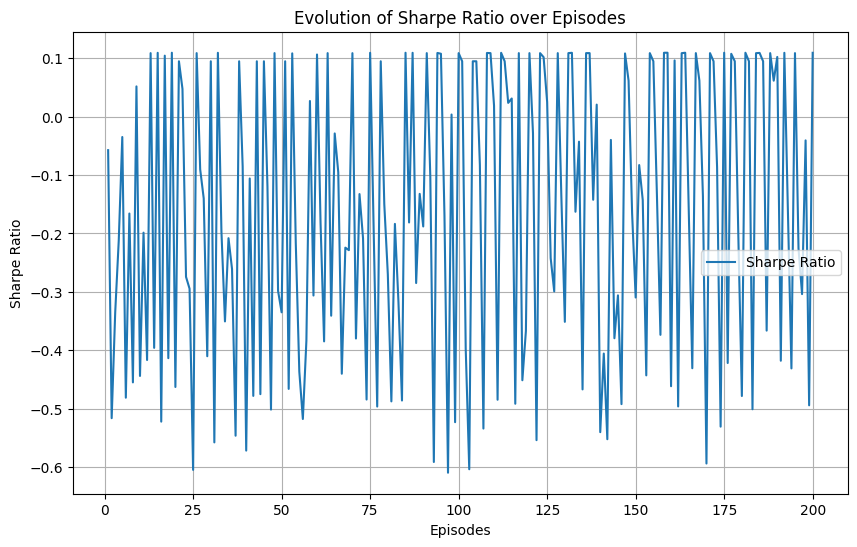

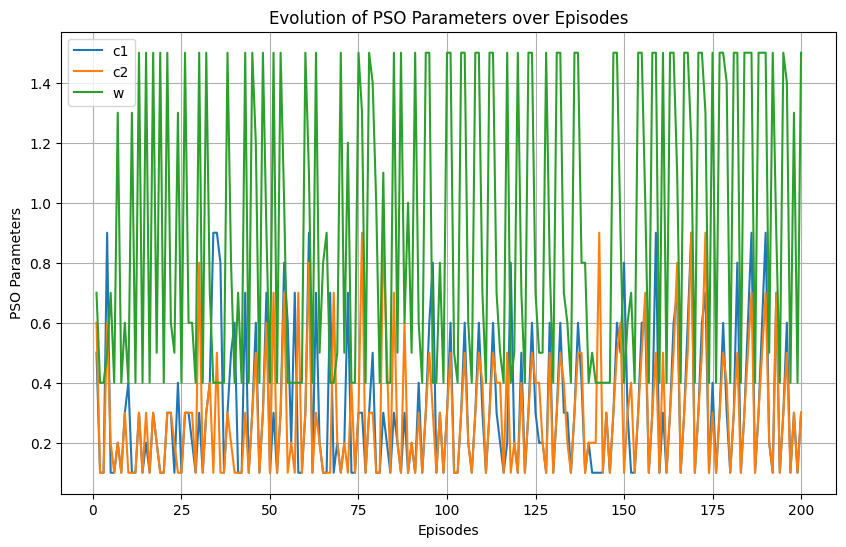

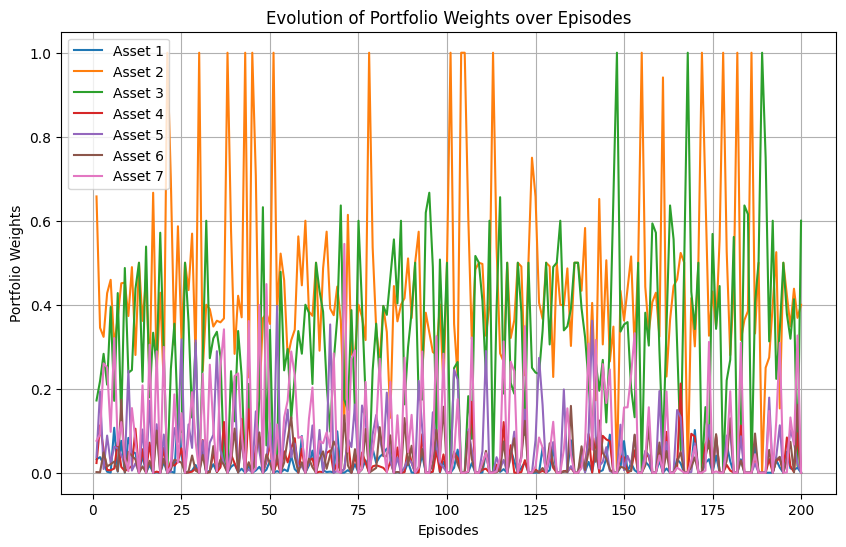

In [24]:
# Imprimir la mejor configuración al final
print("Best Sharpe Ratio:", best_sharpe_ratio)
print("Best Portfolio Weights:", best_portfolio_weights)
print("Best PSO Parameters:", best_pso_params)


# Graficar el Sharpe Ratio a lo largo de los episodios
plt.figure(figsize=(10, 6))
plt.plot(episodes, sharpe_ratios, label='Sharpe Ratio')
plt.xlabel('Episodes')
plt.ylabel('Sharpe Ratio')
plt.title('Evolution of Sharpe Ratio over Episodes')
plt.legend()
plt.grid(True)
plt.show()

# Graficar los parámetros PSO a lo largo de los episodios
plt.figure(figsize=(10, 6))
plt.plot(episodes, c1_values, label='c1')
plt.plot(episodes, c2_values, label='c2')
plt.plot(episodes, w_values, label='w')
plt.xlabel('Episodes')
plt.ylabel('PSO Parameters')
plt.title('Evolution of PSO Parameters over Episodes')
plt.legend()
plt.grid(True)
plt.show()

# Graficar las ponderaciones del portafolio a lo largo de los episodios
plt.figure(figsize=(10, 6))
for i in range(num_assets):
    plt.plot(episodes, portfolio_weights[:, i], label=f'Asset {i+1}')
plt.xlabel('Episodes')
plt.ylabel('Portfolio Weights')
plt.title('Evolution of Portfolio Weights over Episodes')
plt.legend()
plt.grid(True)
plt.show()
